# Summary

This notebook is focused on cleaning the Austin housing dataset that was obtained from Zillow.


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\btoli\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load Austin Housing Listing
austin_df = pd.read_csv("../../data/austin_housing_data.csv")
austin_df.head(1)


,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...


---

## Cleaning


In [3]:
# Check dataset shape
austin_df.shape


(15171, 47)

In [4]:
def camel_case_to_snake_case(word):
    """Converts camel case to snake case

    Args:
        word (string): Given word needs to be converted to snake case

    Returns:
        string: Snake case version of the word
    """
    return "".join(
        [f"_{letter.lower()}" if letter.isupper() else letter for letter in word]
    )


In [5]:
# Convert columns to snake case
austin_df.columns = [camel_case_to_snake_case(col) for col in austin_df.columns]


In [6]:
austin_df.isna().sum()


zpid                               0
city                               0
street_address                     0
zipcode                            0
description                        0
latitude                           0
longitude                          0
property_tax_rate                  0
garage_spaces                      0
has_association                    0
has_cooling                        0
has_garage                         0
has_heating                        0
has_spa                            0
has_view                           0
home_type                          0
parking_spaces                     0
year_built                         0
latest_price                       0
num_price_changes                  0
latest_saledate                    0
latest_salemonth                   0
latest_saleyear                    0
latest_price_source                0
num_of_photos                      0
num_of_accessibility_features      0
num_of_appliances                  0
n

> No missing data found


In [7]:
# Drop 0 bedrooms and bathrooms
austin_df = austin_df[
    (austin_df["num_of_bedrooms"] > 0) & (austin_df["num_of_bathrooms"] > 0)
]

# Check dataset shape after removing 0 bedrooms
austin_df.shape


(15034, 47)

In [8]:
# Need to change condo bedroom and bathroom since it seems like mistype
austin_df[austin_df["num_of_bedrooms"] == 20][["num_of_bedrooms", "home_type"]]


,num_of_bedrooms,home_type
8597,20,Condo


In [9]:
austin_df.loc[8597, ["num_of_bedrooms"]] = 2
austin_df.loc[8597, ["num_of_bathrooms"]] = 2


In [10]:
# 27 bathrooms clearly wrong input, changing it to 2.7
austin_df[austin_df["num_of_bathrooms"] == 27][
    ["num_of_bedrooms", "home_type", "num_of_bathrooms"]
]


,num_of_bedrooms,home_type,num_of_bathrooms
2838,4,Single Family,27.0


In [11]:
austin_df.loc[2838, ["num_of_bathrooms"]] = 2.7


In [12]:
# 22 garage_spaces clearly wrong input, changing it to 2
austin_df[austin_df["garage_spaces"] == 22][
    ["num_of_bedrooms", "home_type", "num_of_bathrooms"]
]


,num_of_bedrooms,home_type,num_of_bathrooms
6885,4,Condo,3.0


In [13]:
austin_df.loc[6885, ["garage_spaces"]] = 2


---

## EDA


In [14]:
# Remove columns that does not provide benefits to EDA
remove_columns = [
    "zpid",
    "zipcode",
    "description",
    "latitude",
    "longitude",
    "latest_price_source",
]


<AxesSubplot:>

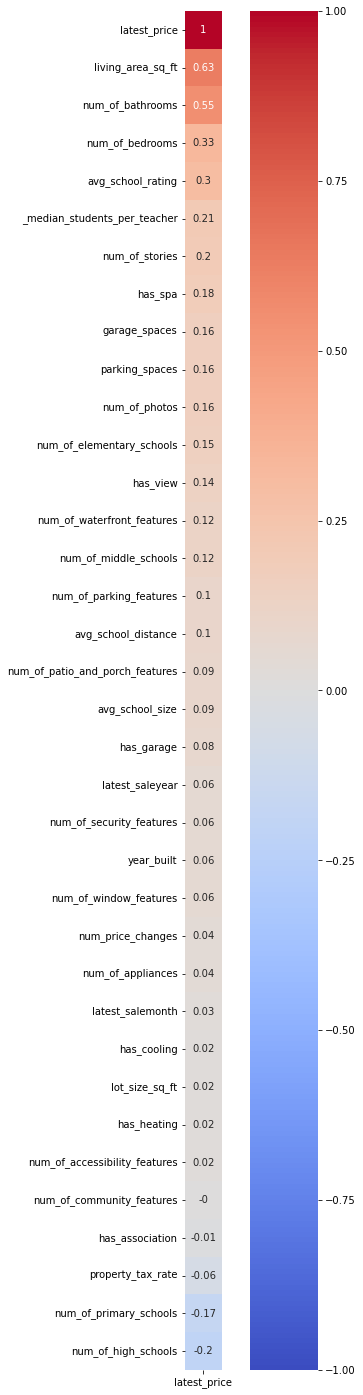

In [15]:
# Get feature price correlation
price_corr = (
    austin_df.drop(columns=remove_columns)
    .corr()[["latest_price"]]
    .sort_values(by="latest_price", ascending=False)
)

# Round correlation
corr = round(
    price_corr,
    2,
)

# Plot heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(corr, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


<AxesSubplot:title={'center':'Price Distribution'}, xlabel='latest_price', ylabel='Count'>

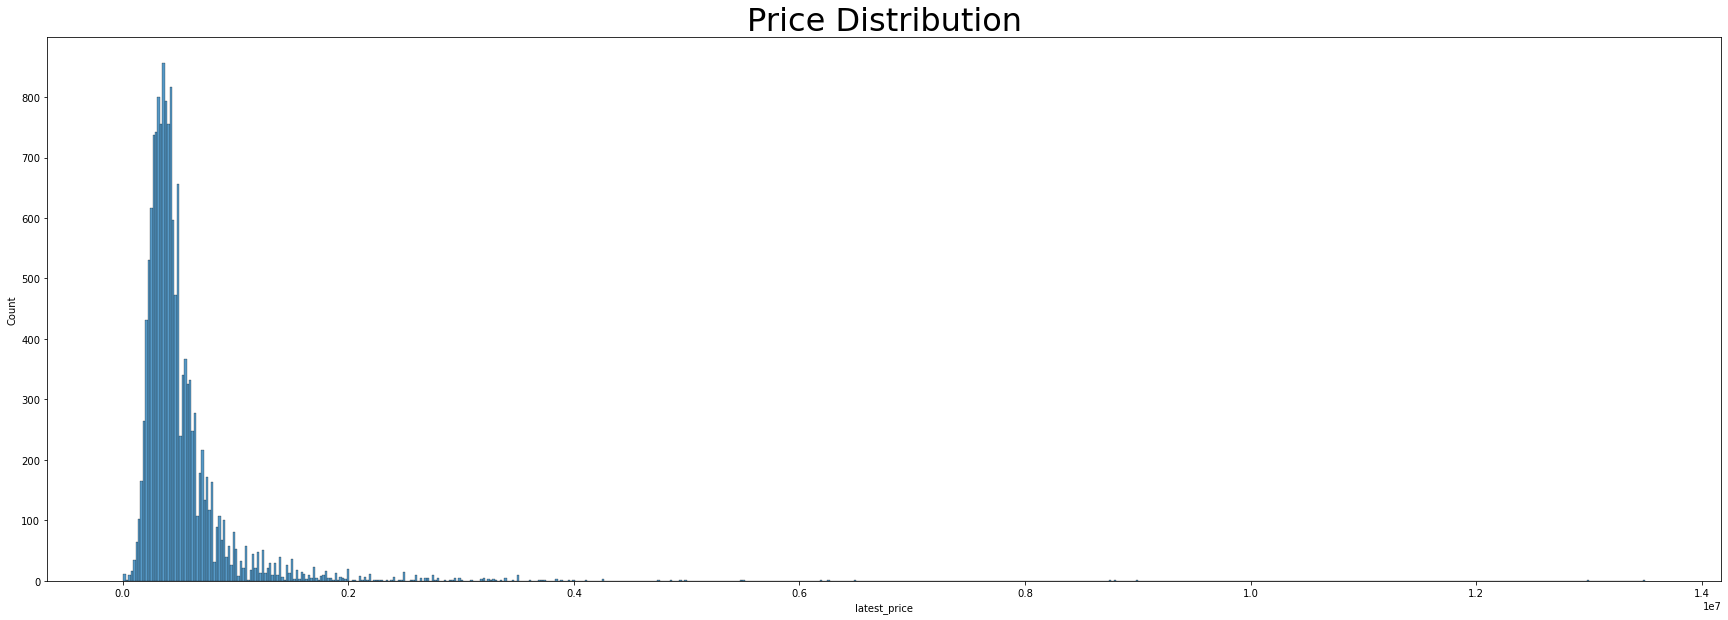

In [16]:
# Plot distribution of price
plt.figure(figsize=(30, 10))
plt.title("Price Distribution", fontsize=32)
sns.histplot(data=austin_df, x="latest_price")


> Distribution is heavily right skewed and need to remove outliers


<AxesSubplot:title={'center':'Price Outliers'}, xlabel='latest_price'>

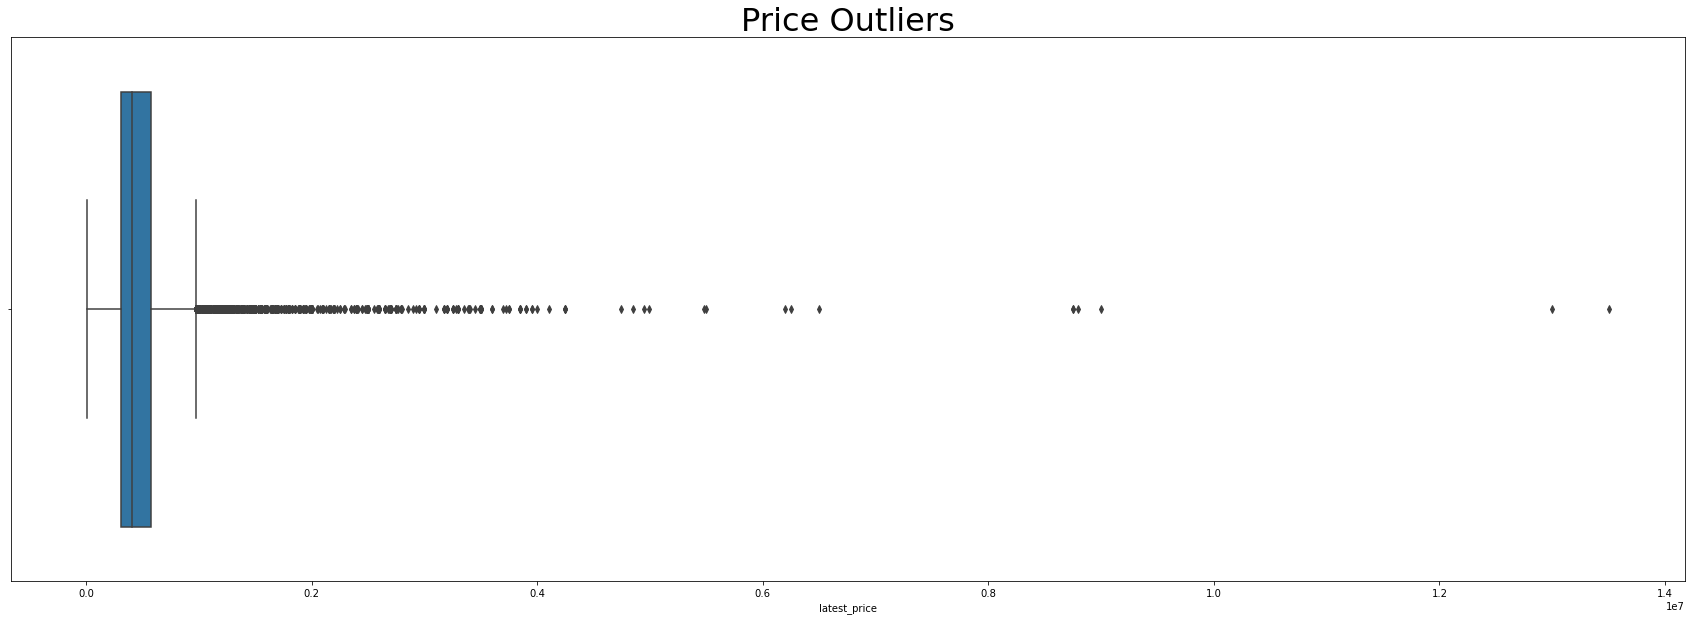

In [17]:
plt.figure(figsize=(30, 10))
plt.title("Price Outliers", fontsize=32)
sns.boxplot(x=austin_df["latest_price"])


In [18]:
mean_price = round(austin_df["latest_price"].mean(), 2)
median_price = round(austin_df["latest_price"].median(), 2)
quantile_88th = round(austin_df["latest_price"].quantile(0.88), 2)

print(
    f"Mean Price: ${mean_price}\nMedian Price: ${median_price}\n88th Percentile Price: ${quantile_88th}"
)


Mean Price: $511963.12
Median Price: $405000.0
88th Percentile Price: $774900.0


In [19]:
austin_df = austin_df[
    (austin_df["latest_price"] < quantile_88th) & (austin_df["latest_price"] > 100_000)
]

# Check shape after removing outliers
austin_df.shape


(13167, 47)

<AxesSubplot:title={'center':'Price After Removing Outliers'}, xlabel='latest_price'>

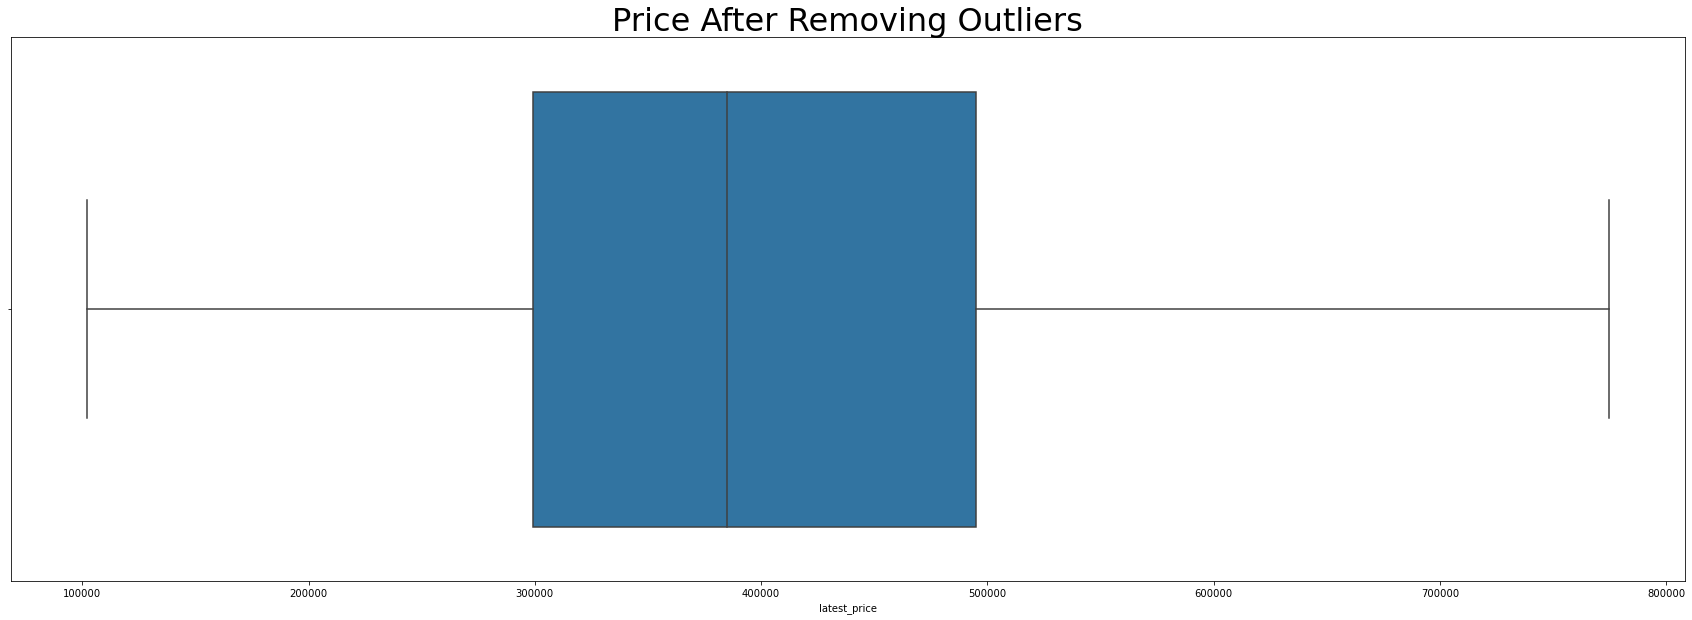

In [20]:
plt.figure(figsize=(30, 10))
plt.title("Price After Removing Outliers", fontsize=32)
sns.boxplot(x=austin_df["latest_price"])


<AxesSubplot:title={'center':'Price Distribution After Removing Outliers'}, xlabel='latest_price', ylabel='Count'>

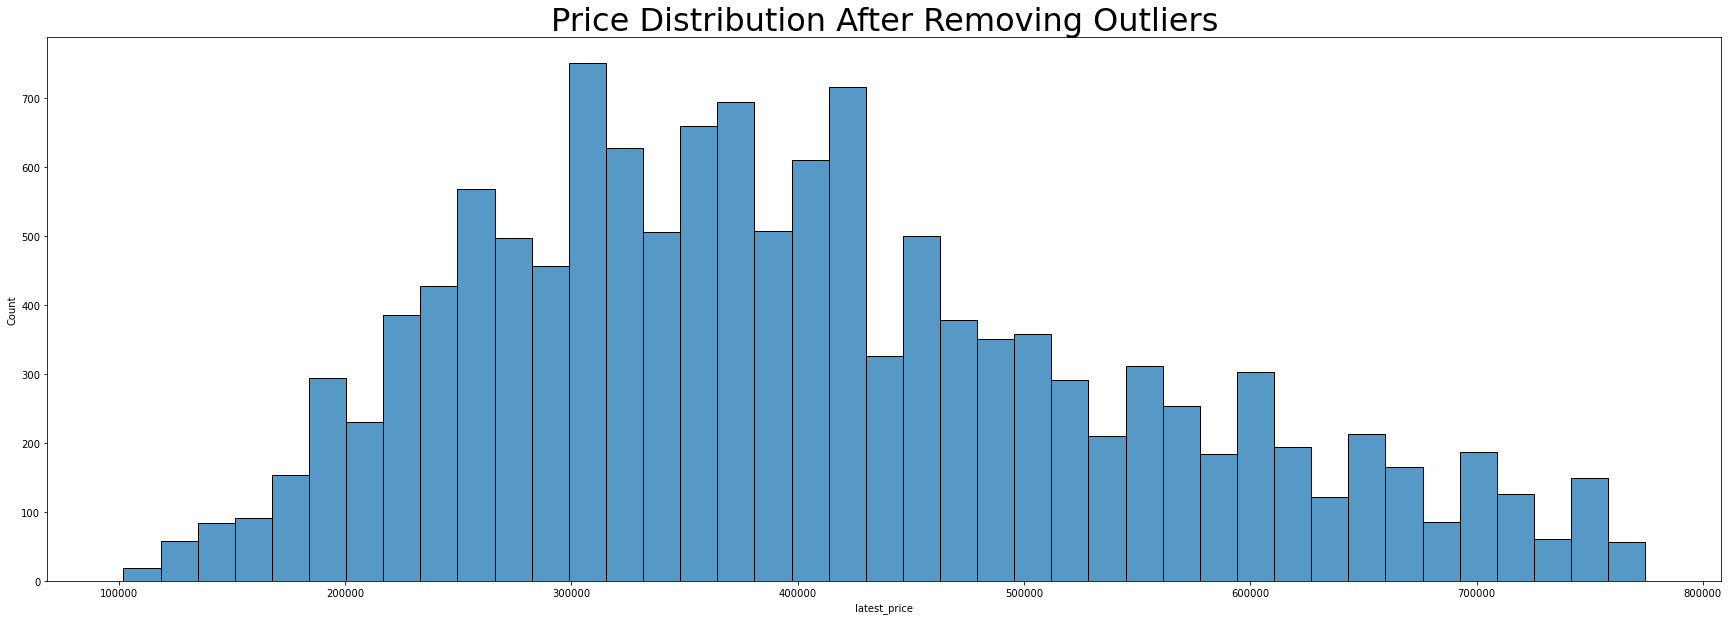

In [21]:
# Plot price distribution after removing outliers
plt.figure(figsize=(30, 10))
plt.title("Price Distribution After Removing Outliers", fontsize=32)
sns.histplot(data=austin_df, x="latest_price")


> Removing outliers and below $100,000 house prices, distribution is more balanced


<AxesSubplot:>

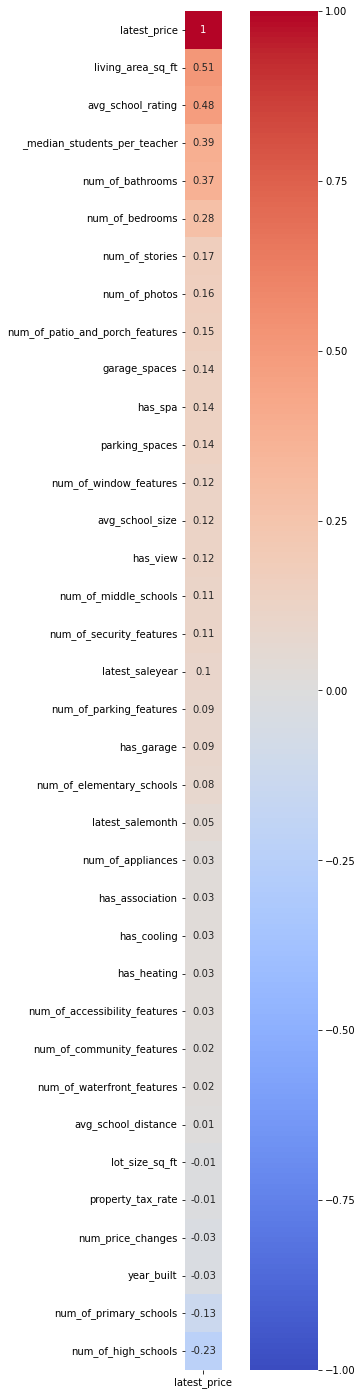

In [22]:
# Get feature price correlation after removing outliers
price_corr = (
    austin_df.drop(columns=remove_columns)
    .corr()[["latest_price"]]
    .sort_values(by="latest_price", ascending=False)
)

# Round correlation
corr = round(
    price_corr,
    2,
)

# Plot heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(corr, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


In [23]:
austin_df[["longitude", "latitude"]].min()


longitude   -98.022057
latitude     30.085030
dtype: float64

In [24]:
austin_df[["longitude", "latitude"]].max()


longitude   -97.570633
latitude     30.517323
dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

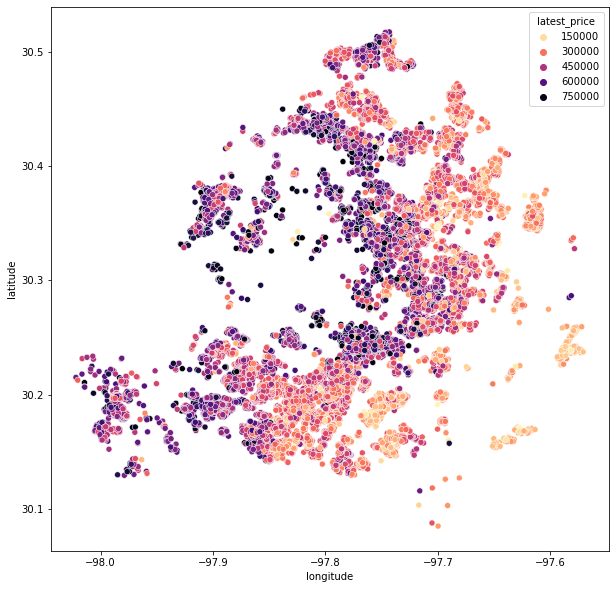

In [25]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=austin_df, x="longitude", y="latitude", hue="latest_price", palette="magma_r"
)


<AxesSubplot:title={'center':'Price Distribution By City'}, xlabel='city', ylabel='latest_price'>

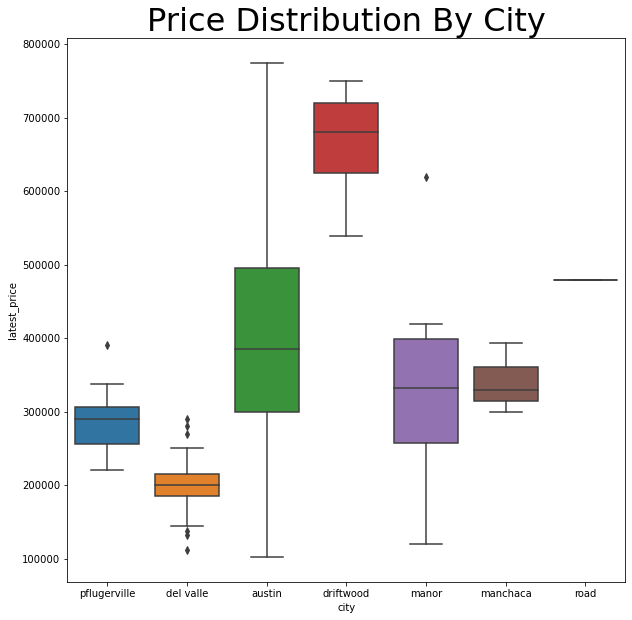

In [26]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By City", fontsize=32)
sns.boxplot(data=austin_df, x="city", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Having HOA'}, xlabel='has_association', ylabel='latest_price'>

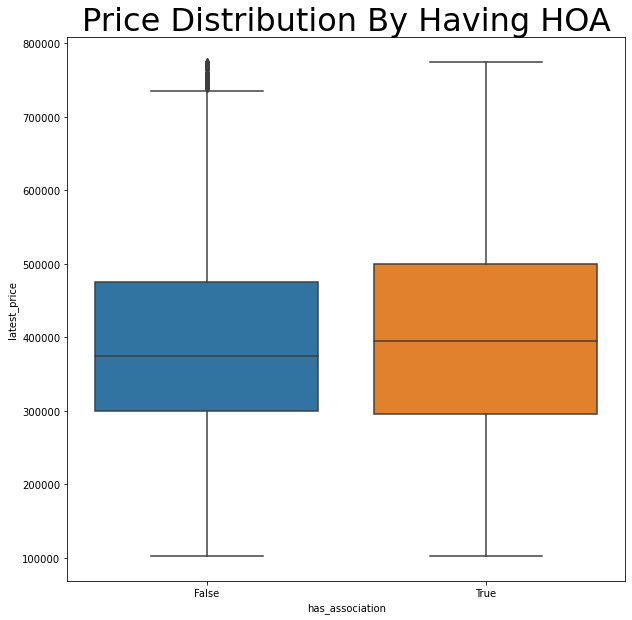

In [27]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having HOA", fontsize=32)
sns.boxplot(data=austin_df, x="has_association", y="latest_price")


> Having HOA slightly moves price median


<AxesSubplot:title={'center':'Price Distribution By Having Cooling System'}, xlabel='has_cooling', ylabel='latest_price'>

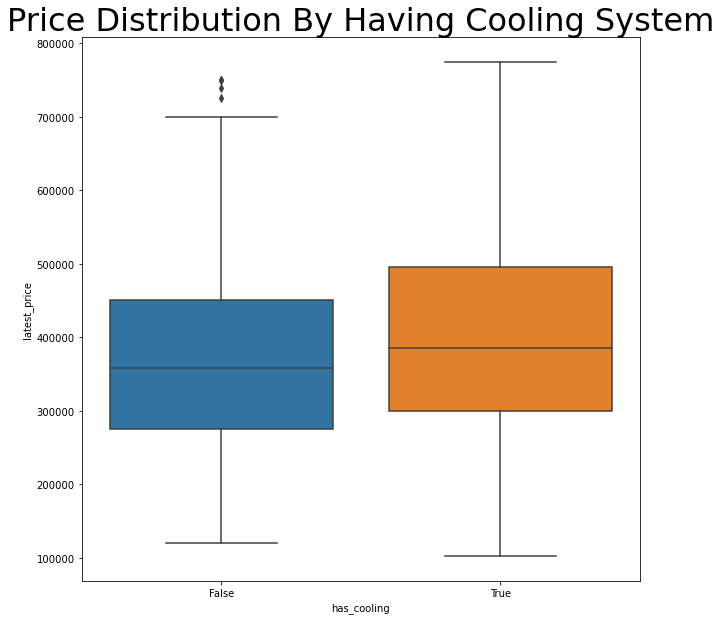

In [28]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Cooling System", fontsize=32)
sns.boxplot(data=austin_df, x="has_cooling", y="latest_price")


> House with cooling increased overall price median


<AxesSubplot:title={'center':'Price Distribution By Having Heating'}, xlabel='has_heating', ylabel='latest_price'>

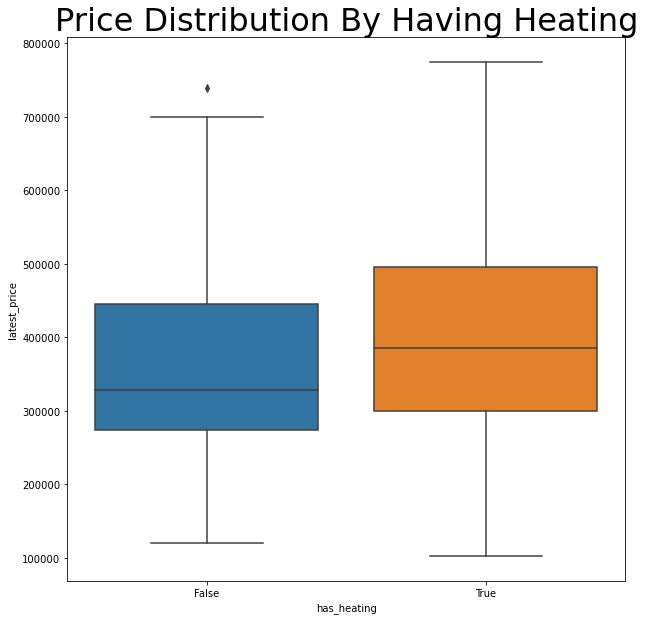

In [29]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Heating", fontsize=32)
sns.boxplot(data=austin_df, x="has_heating", y="latest_price")


> House with heating increased house price median


<AxesSubplot:title={'center':'Price Distribution By Having Garage'}, xlabel='has_garage', ylabel='latest_price'>

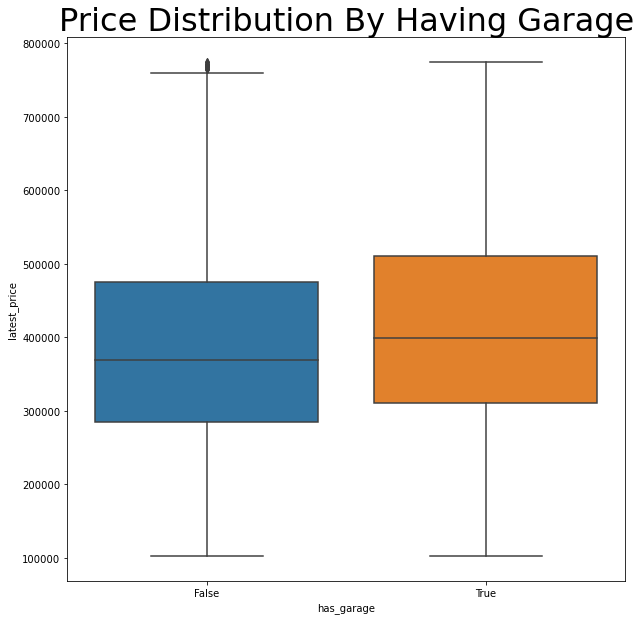

In [30]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Garage", fontsize=32)
sns.boxplot(data=austin_df, x="has_garage", y="latest_price")


> Having a garage has slight increase on house price


<AxesSubplot:title={'center':'Price Distribution By Having SPA'}, xlabel='has_spa', ylabel='latest_price'>

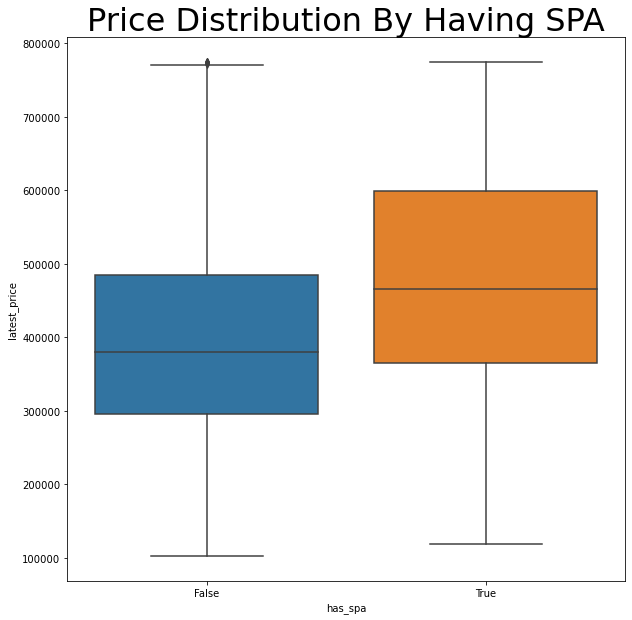

In [31]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having SPA", fontsize=32)
sns.boxplot(data=austin_df, x="has_spa", y="latest_price")


> House having a spa increased


<AxesSubplot:title={'center':'Price Distribution By Having View'}, xlabel='has_view', ylabel='latest_price'>

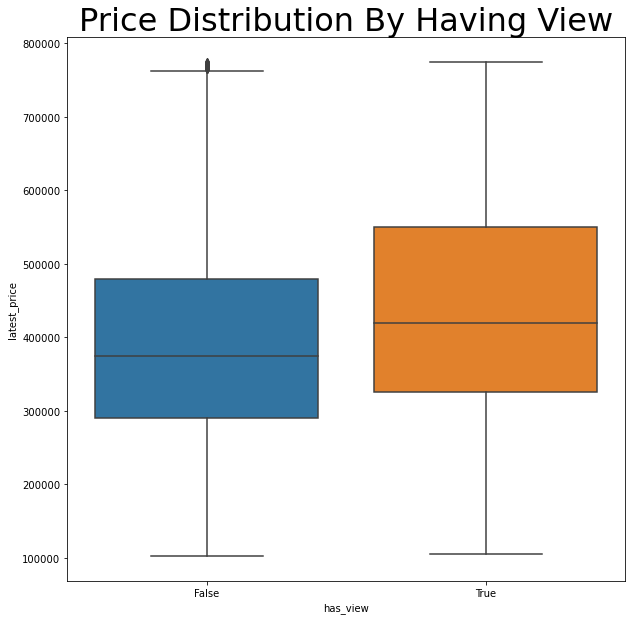

In [32]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having View", fontsize=32)
sns.boxplot(data=austin_df, x="has_view", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Home Type'}, xlabel='home_type', ylabel='latest_price'>

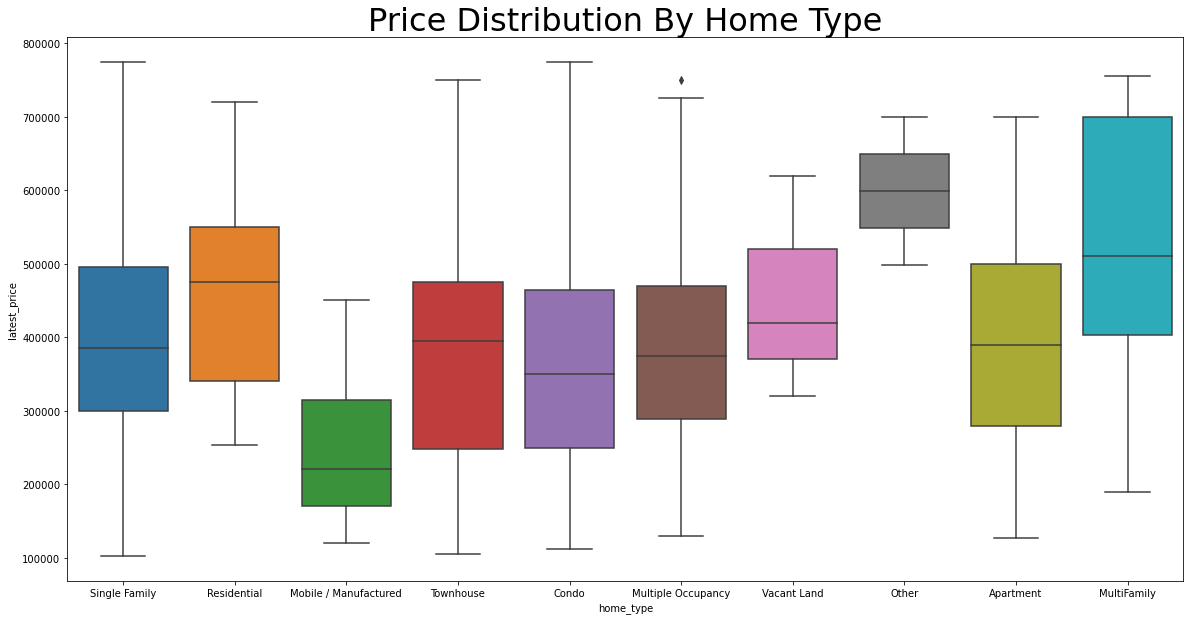

In [33]:
plt.figure(figsize=(20, 10))
plt.title("Price Distribution By Home Type", fontsize=32)
sns.boxplot(data=austin_df, x="home_type", y="latest_price")


> Home type has influence on house pricing


<AxesSubplot:title={'center':'Price Distribution By Parking Spaces'}, xlabel='parking_spaces', ylabel='latest_price'>

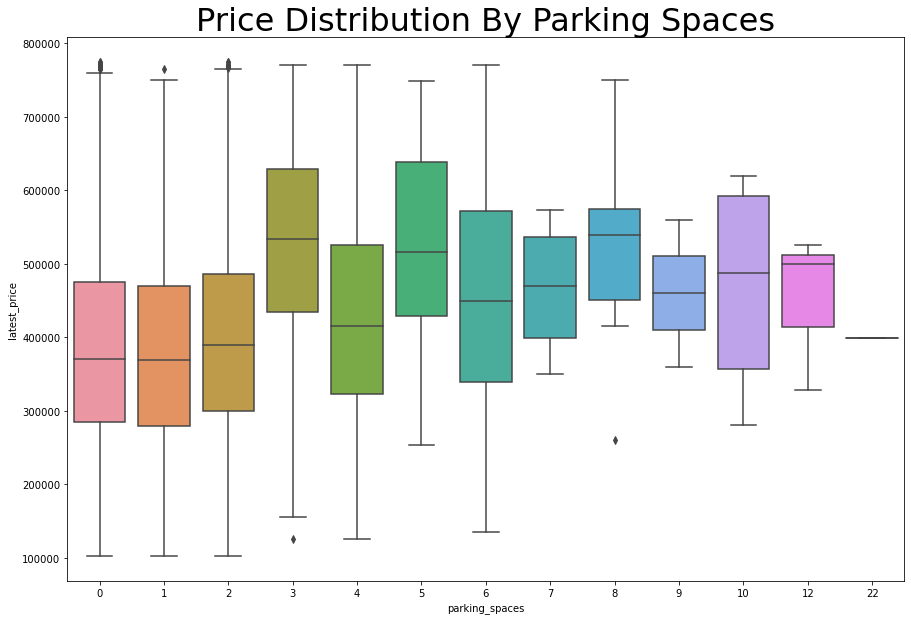

In [34]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Parking Spaces", fontsize=32)
sns.boxplot(data=austin_df, x="parking_spaces", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Price Changes'}, xlabel='num_price_changes', ylabel='latest_price'>

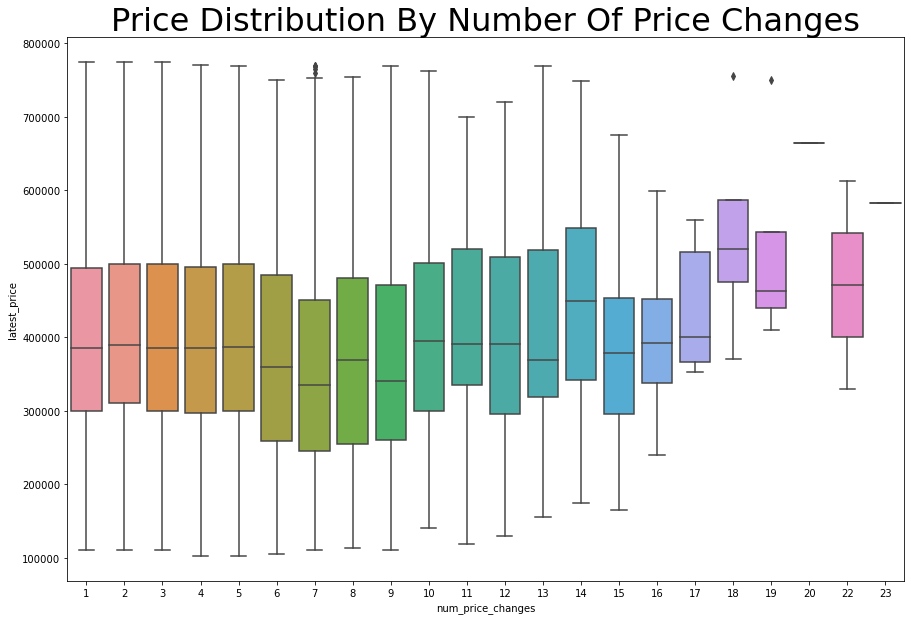

In [35]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Price Changes", fontsize=32)
sns.boxplot(data=austin_df, x="num_price_changes", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Sale Month'}, xlabel='latest_salemonth', ylabel='latest_price'>

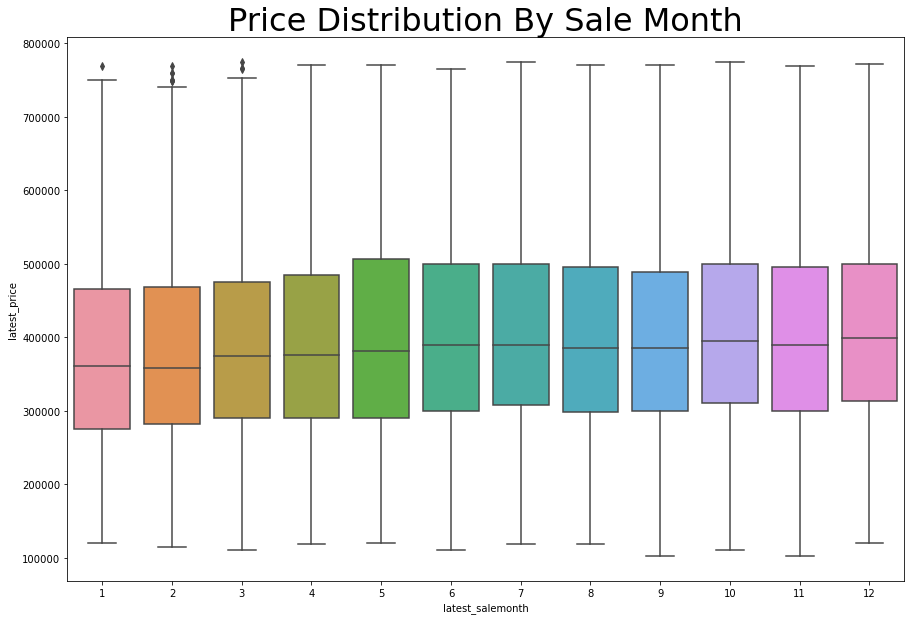

In [36]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Sale Month", fontsize=32)
sns.boxplot(data=austin_df, x="latest_salemonth", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Sale Year'}, xlabel='latest_saleyear', ylabel='latest_price'>

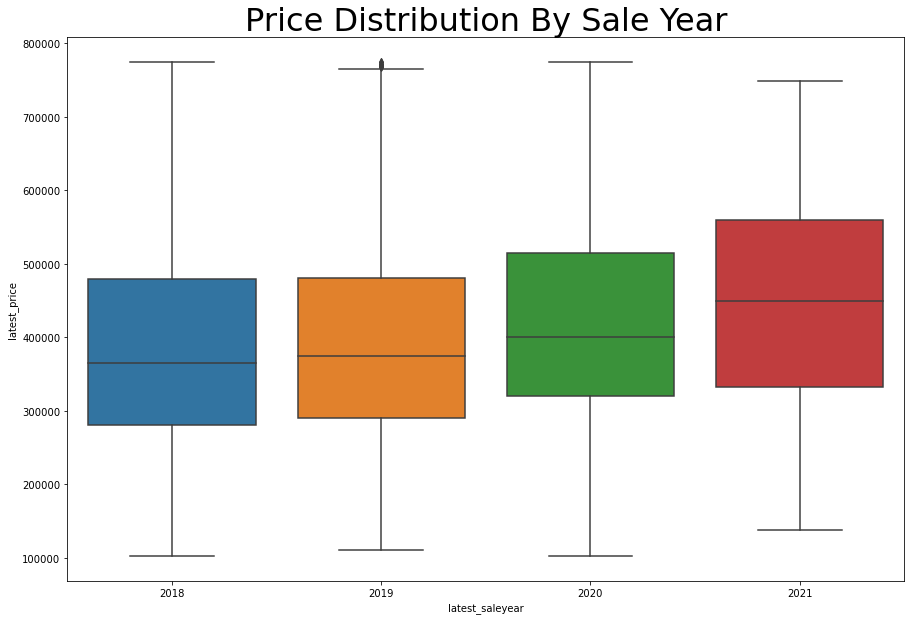

In [37]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Sale Year", fontsize=32)
sns.boxplot(data=austin_df, x="latest_saleyear", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Accessibility Features'}, xlabel='num_of_accessibility_features', ylabel='latest_price'>

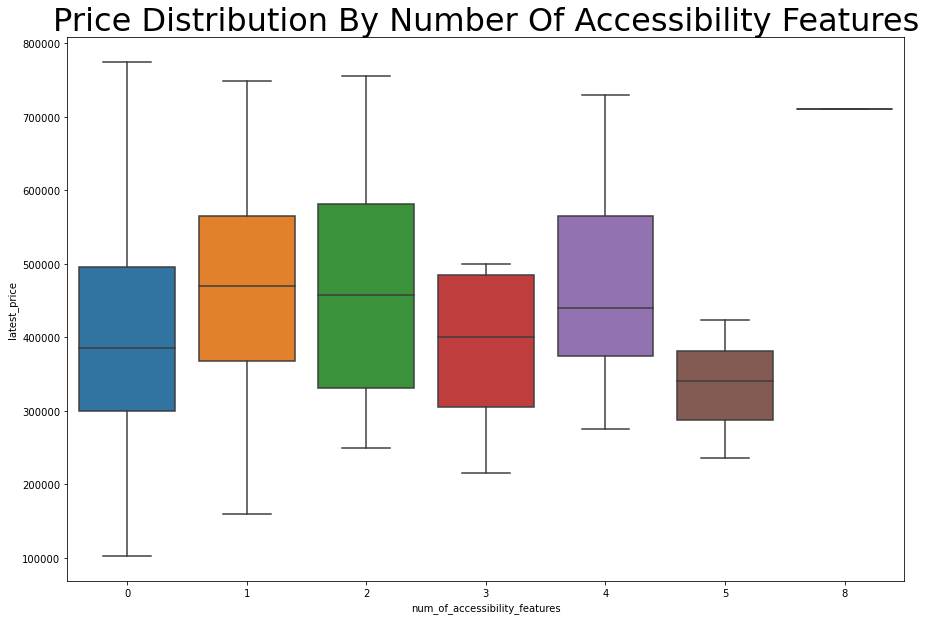

In [38]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Accessibility Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_accessibility_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Appliances'}, xlabel='num_of_appliances', ylabel='latest_price'>

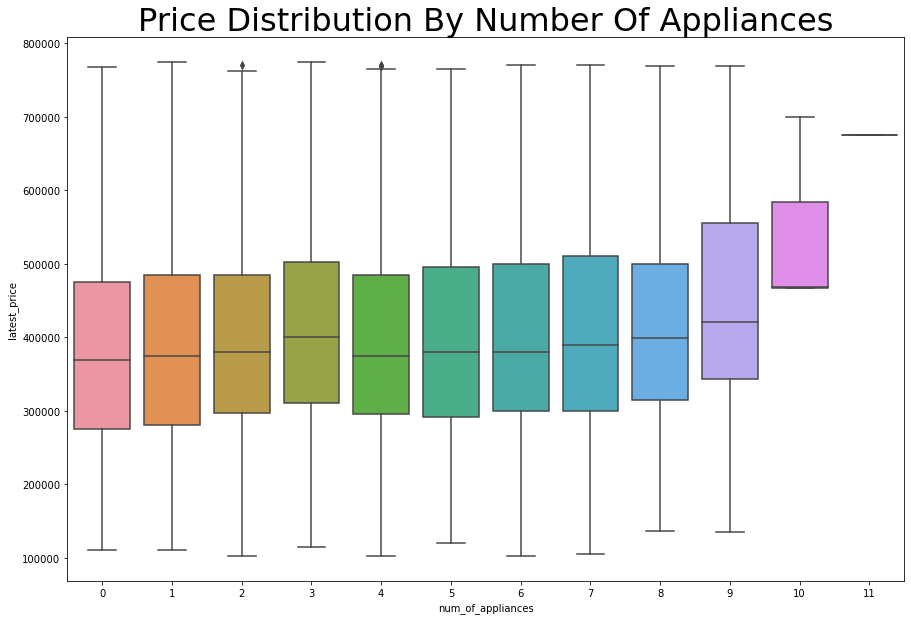

In [39]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Appliances", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_appliances", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Parking Features'}, xlabel='num_of_parking_features', ylabel='latest_price'>

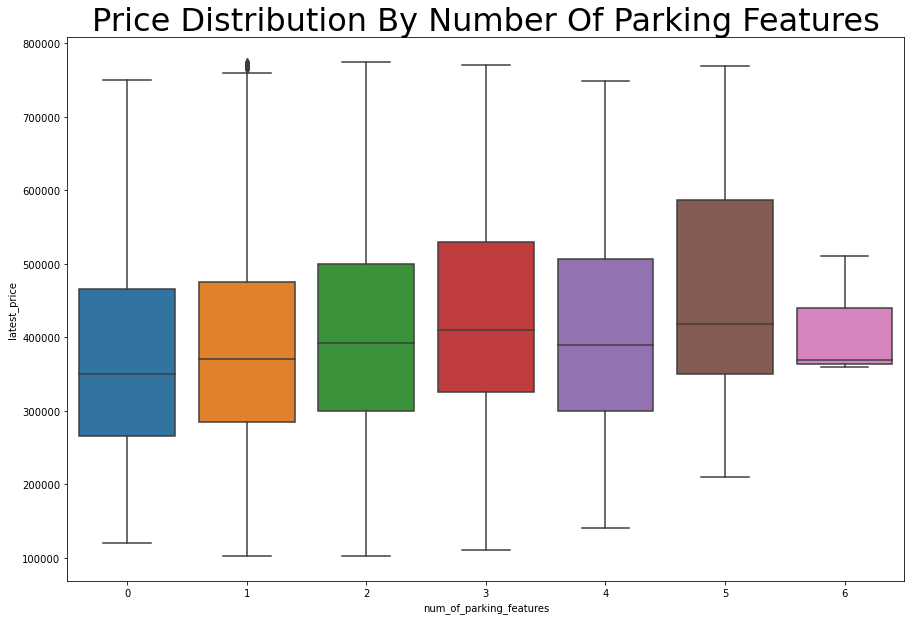

In [40]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Parking Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_parking_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Patio and Porch'}, xlabel='num_of_patio_and_porch_features', ylabel='latest_price'>

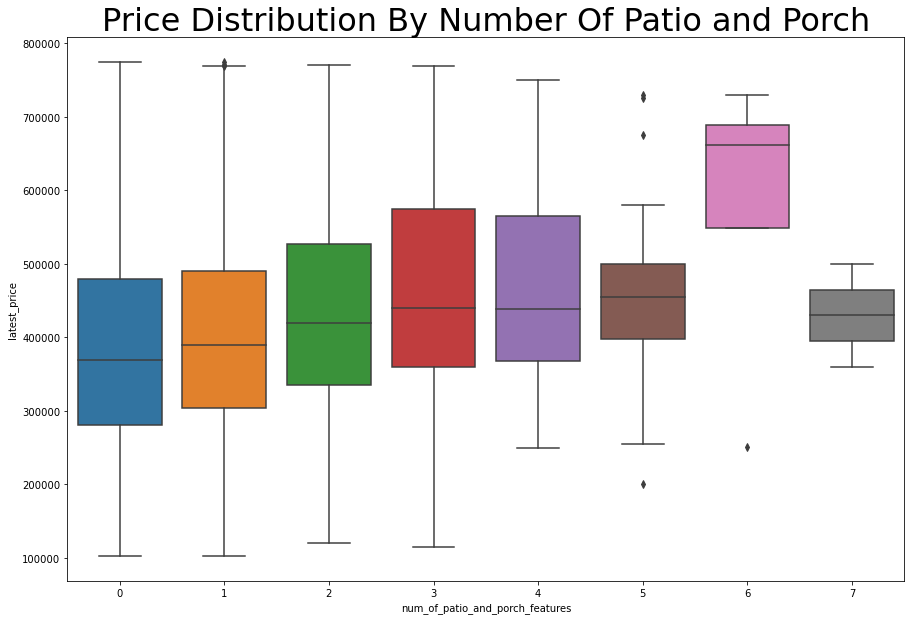

In [41]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Patio and Porch", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_patio_and_porch_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Security'}, xlabel='num_of_security_features', ylabel='latest_price'>

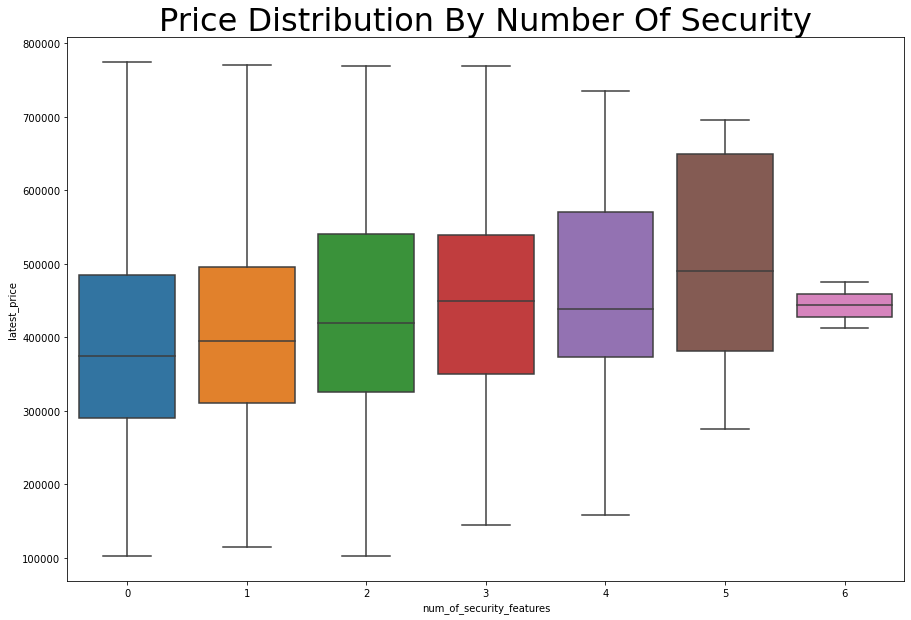

In [42]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Security", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_security_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Waterfront'}, xlabel='num_of_waterfront_features', ylabel='latest_price'>

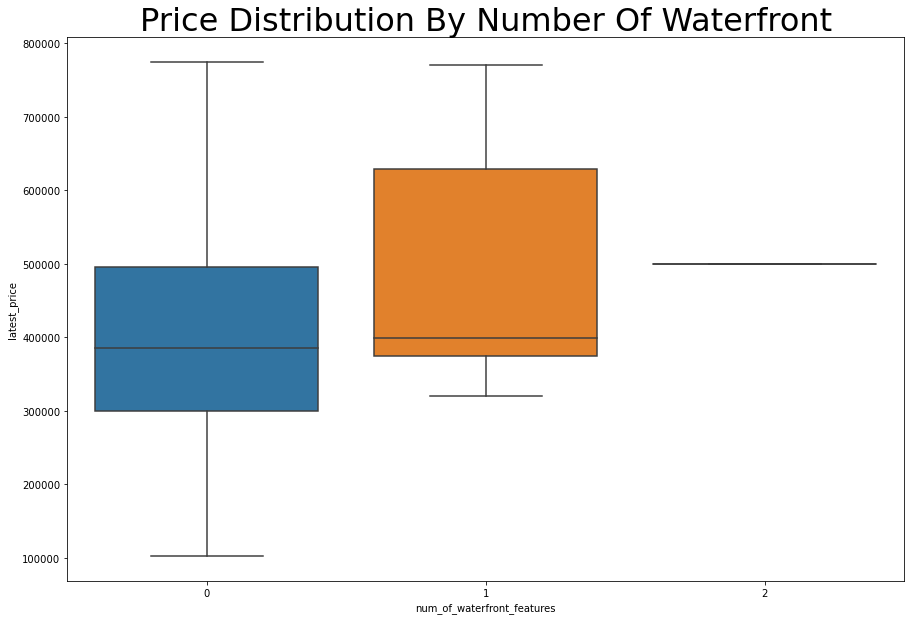

In [43]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Waterfront", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_waterfront_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Window'}, xlabel='num_of_window_features', ylabel='latest_price'>

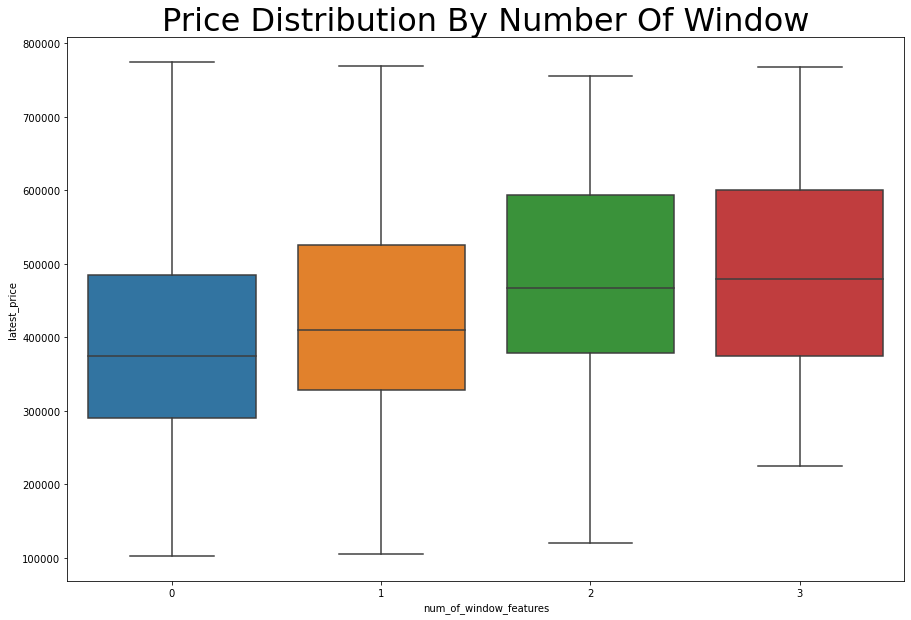

In [44]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Window", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_window_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Community Features'}, xlabel='num_of_community_features', ylabel='latest_price'>

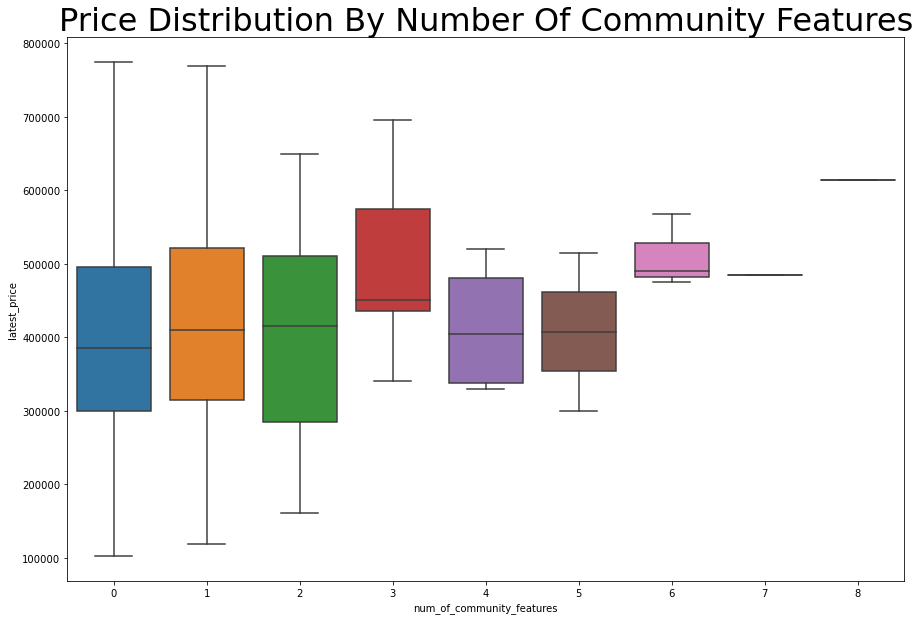

In [45]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Community Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_community_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Primary Schools'}, xlabel='num_of_primary_schools', ylabel='latest_price'>

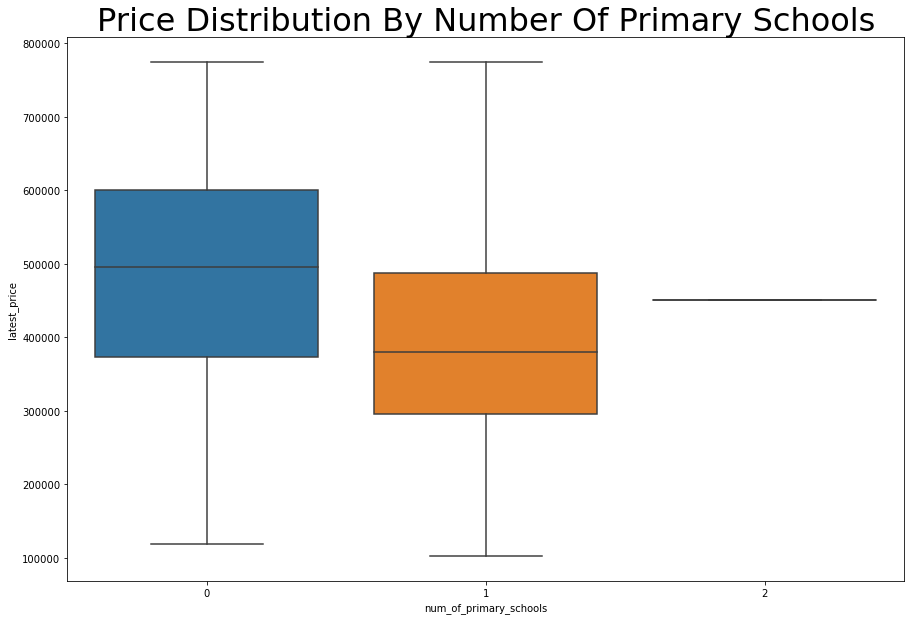

In [46]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Primary Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_primary_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Elementary Schools'}, xlabel='num_of_elementary_schools', ylabel='latest_price'>

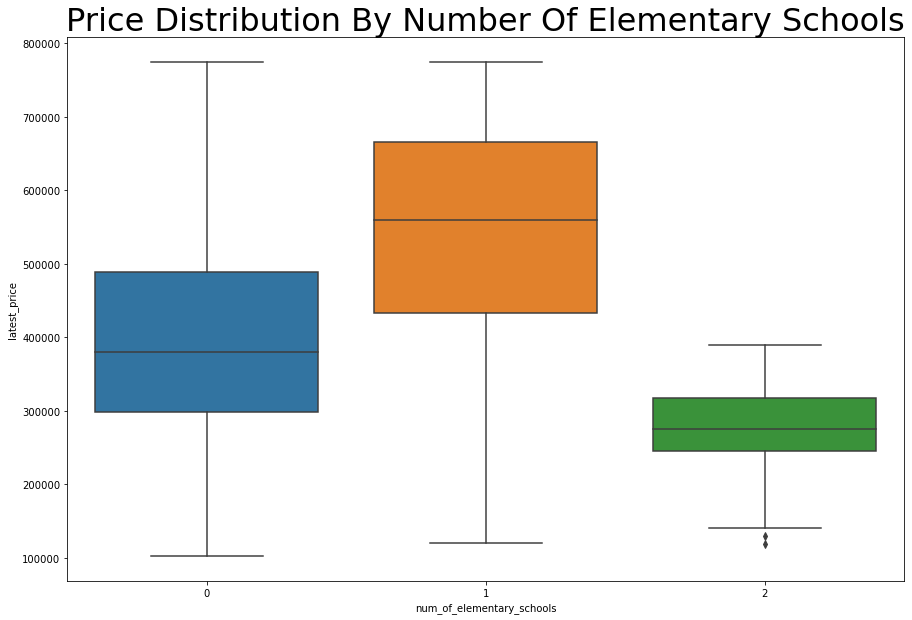

In [47]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Elementary Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_elementary_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Middle Schools'}, xlabel='num_of_middle_schools', ylabel='latest_price'>

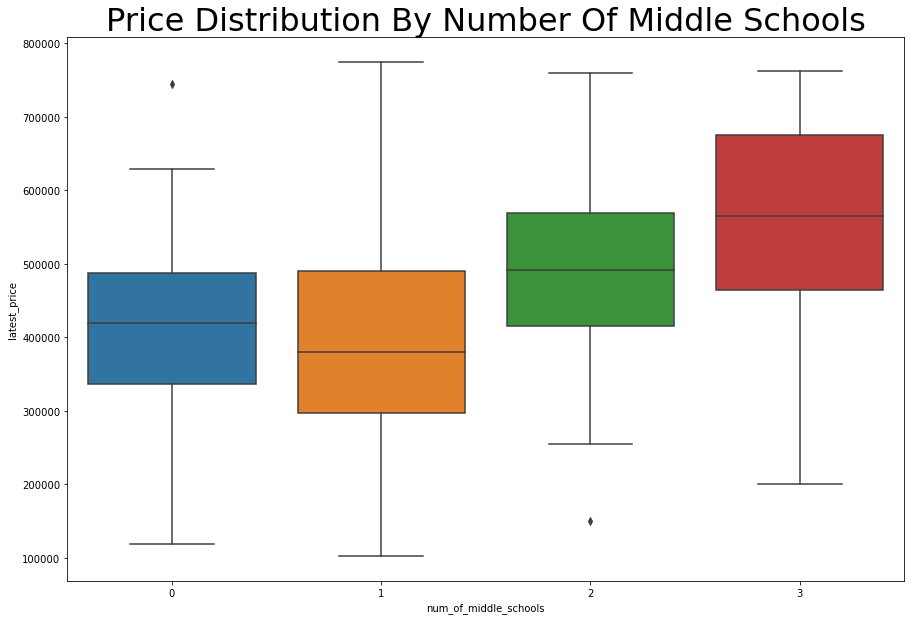

In [48]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Middle Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_middle_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of High Schools'}, xlabel='num_of_high_schools', ylabel='latest_price'>

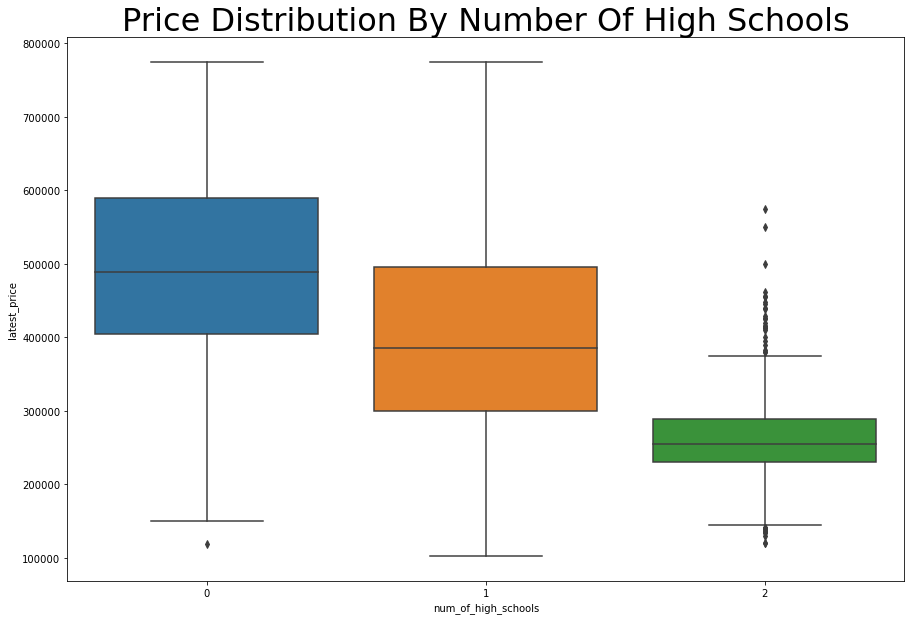

In [49]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of High Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_high_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Median Students Per Teacher'}, xlabel='_median_students_per_teacher', ylabel='latest_price'>

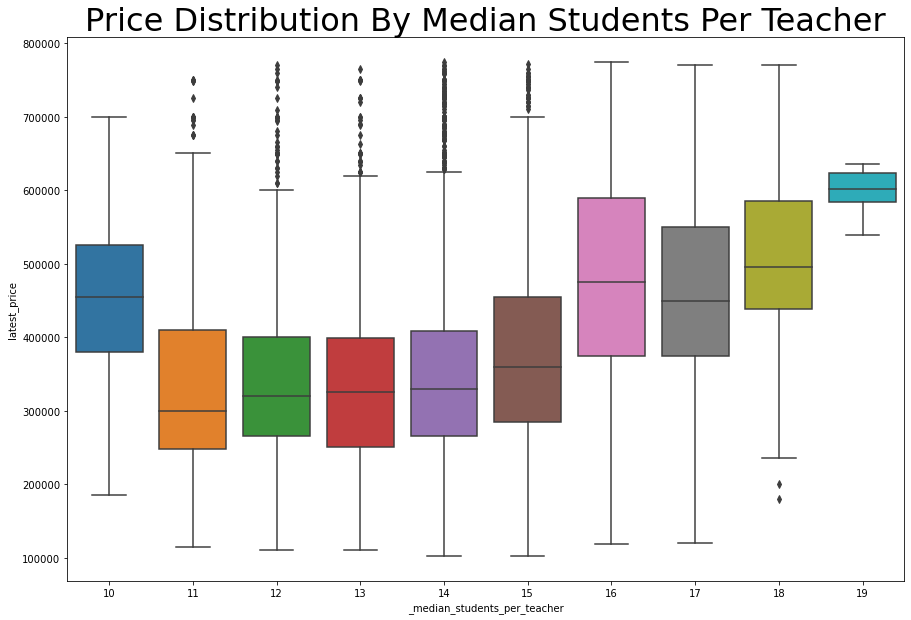

In [50]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Median Students Per Teacher", fontsize=32)
sns.boxplot(data=austin_df, x="_median_students_per_teacher", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Bathrooms'}, xlabel='num_of_bathrooms', ylabel='latest_price'>

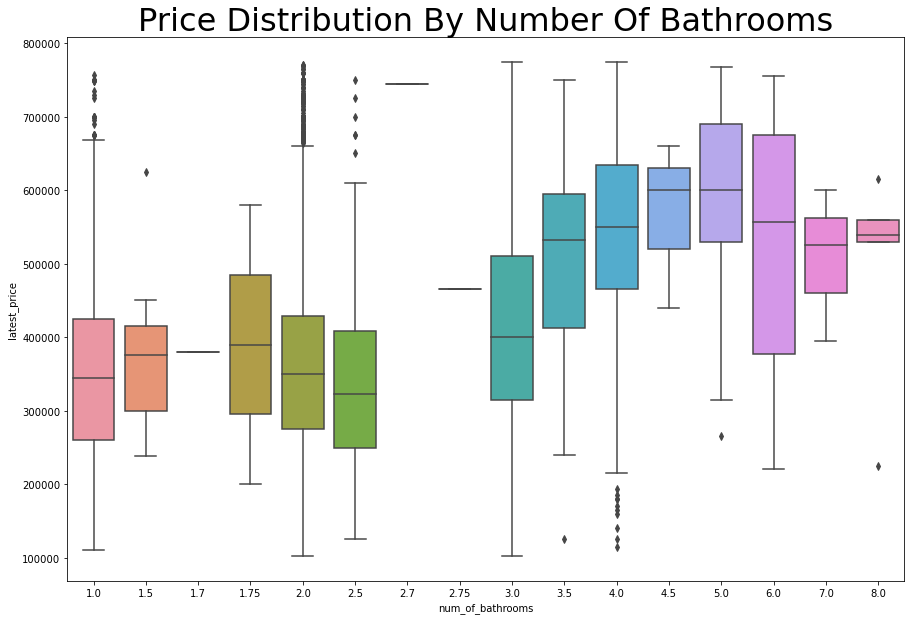

In [51]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Bathrooms", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_bathrooms", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Bedrooms'}, xlabel='num_of_bedrooms', ylabel='latest_price'>

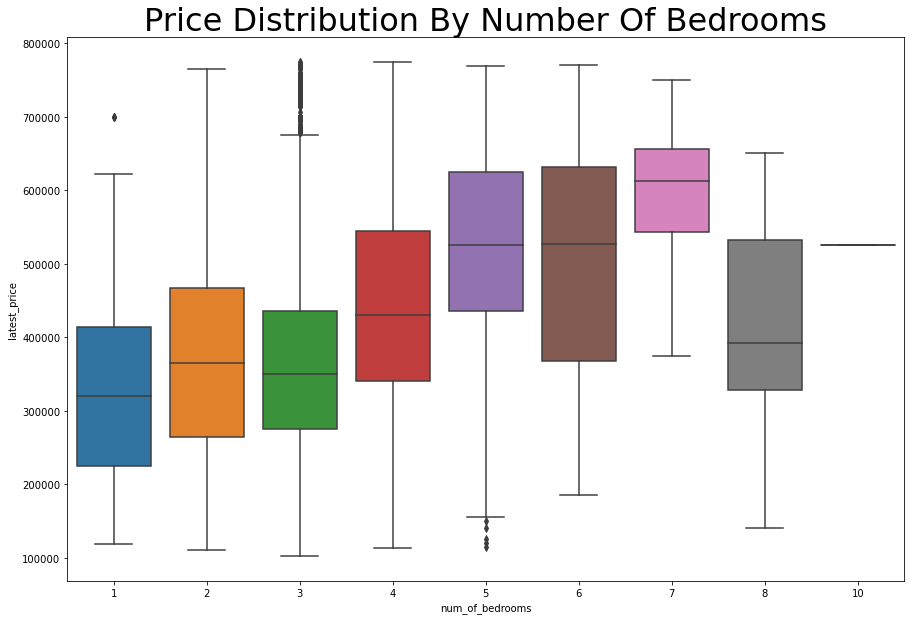

In [52]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Bedrooms", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_bedrooms", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Stories'}, xlabel='num_of_stories', ylabel='latest_price'>

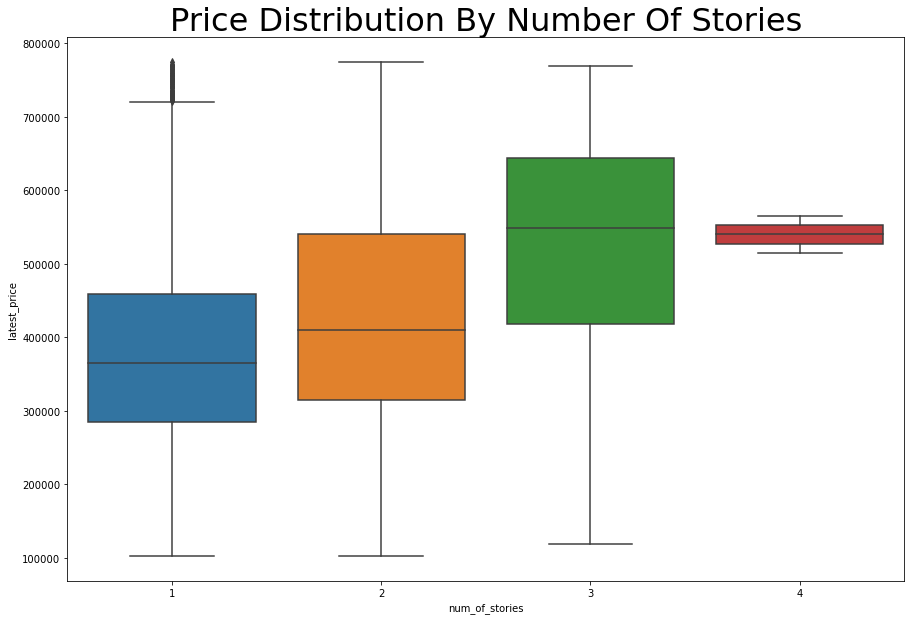

In [53]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Stories", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_stories", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Property Tax Rate'}, xlabel='property_tax_rate', ylabel='latest_price'>

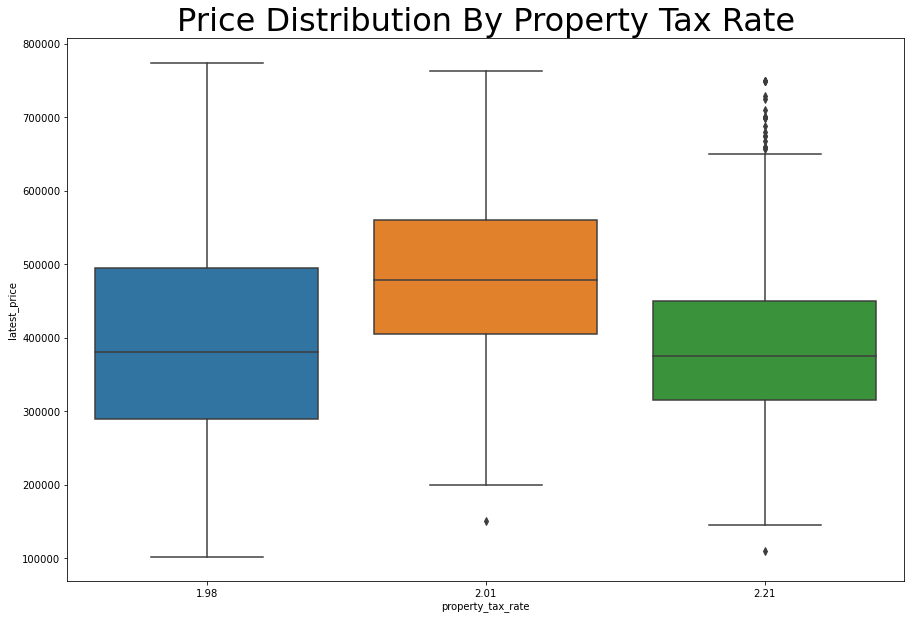

In [54]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Property Tax Rate", fontsize=32)
sns.boxplot(data=austin_df, x="property_tax_rate", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Garage Spaces'}, xlabel='garage_spaces', ylabel='latest_price'>

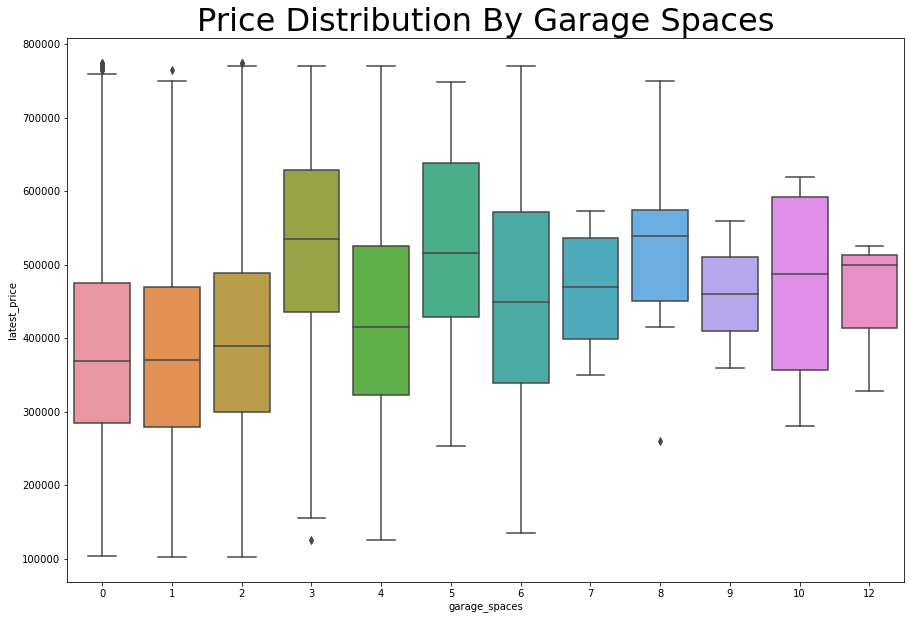

In [55]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Garage Spaces", fontsize=32)
sns.boxplot(data=austin_df, x="garage_spaces", y="latest_price")


<AxesSubplot:title={'center':'Price By Year Built'}, xlabel='year_built', ylabel='latest_price'>

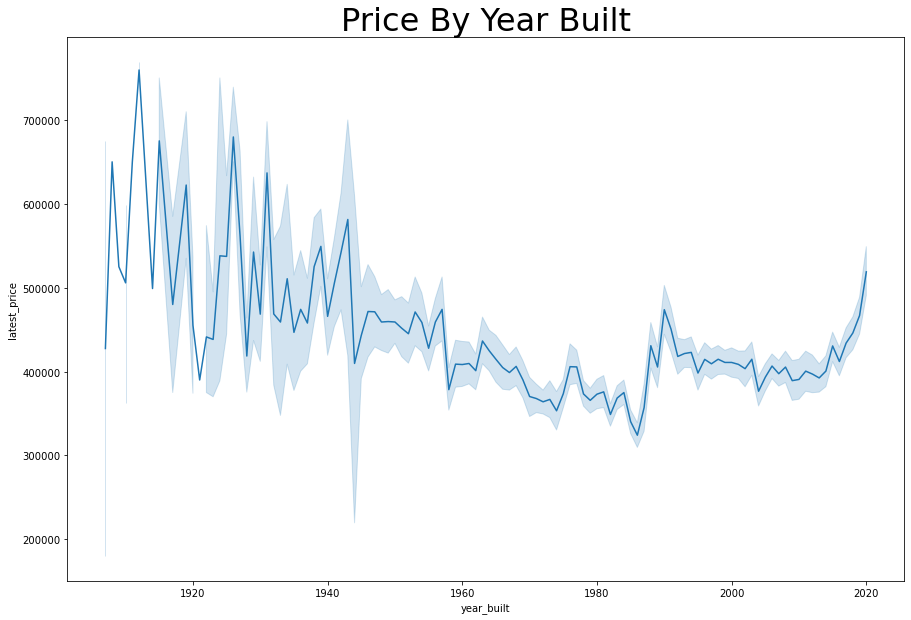

In [56]:
plt.figure(figsize=(15, 10))
plt.title("Price By Year Built", fontsize=32)
sns.lineplot(data=austin_df, x="year_built", y="latest_price")


<AxesSubplot:title={'center':'Price By Number Of Photos'}, xlabel='num_of_photos', ylabel='latest_price'>

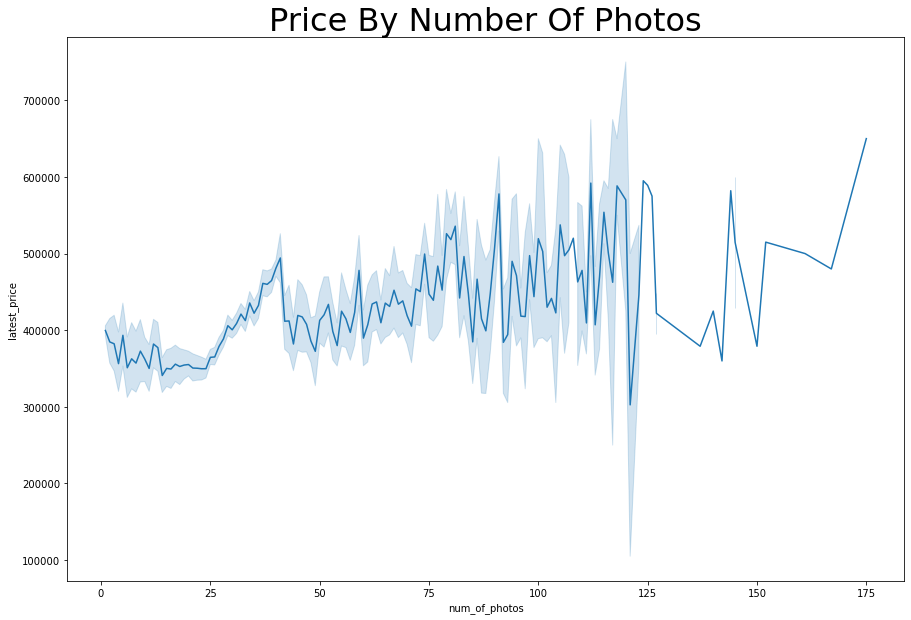

In [57]:
plt.figure(figsize=(15, 10))
plt.title("Price By Number Of Photos", fontsize=32)
sns.lineplot(data=austin_df, x="num_of_photos", y="latest_price")


<AxesSubplot:title={'center':'Price By Lot Size Sq Ft'}, xlabel='lot_size_sq_ft', ylabel='latest_price'>

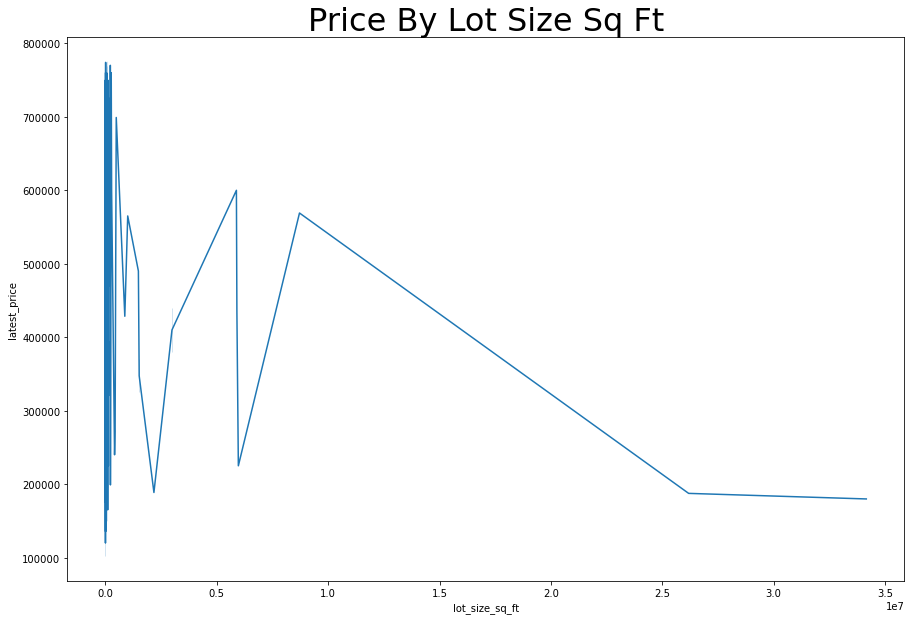

In [58]:
plt.figure(figsize=(15, 10))
plt.title("Price By Lot Size Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="lot_size_sq_ft", y="latest_price")


In [59]:
lot_99th = austin_df["lot_size_sq_ft"].quantile(0.99)
austin_df = austin_df[austin_df["lot_size_sq_ft"] < lot_99th]


<AxesSubplot:title={'center':'Price By Lot Size Sq Ft'}, xlabel='lot_size_sq_ft', ylabel='latest_price'>

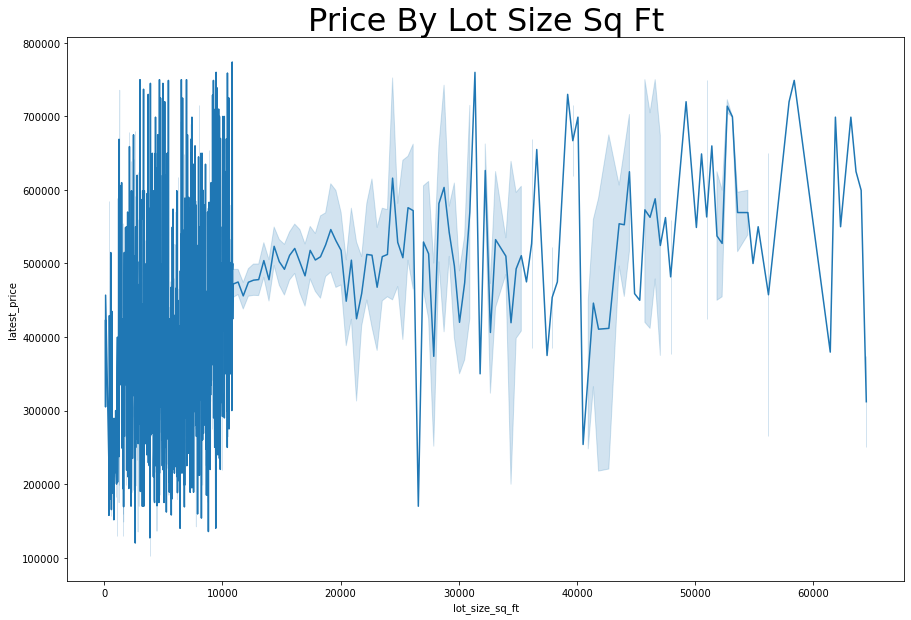

In [60]:
plt.figure(figsize=(15, 10))
plt.title("Price By Lot Size Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="lot_size_sq_ft", y="latest_price")


<AxesSubplot:title={'center':'Price By Living Area Sq Ft'}, xlabel='living_area_sq_ft', ylabel='latest_price'>

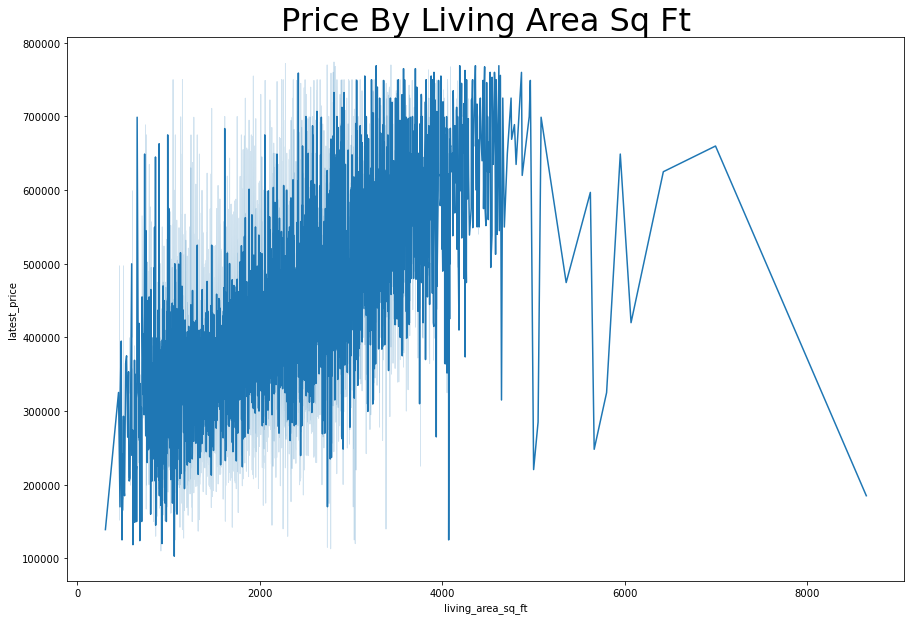

In [61]:
plt.figure(figsize=(15, 10))
plt.title("Price By Living Area Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="living_area_sq_ft", y="latest_price")


In [62]:
living_area_99th = austin_df["living_area_sq_ft"].quantile(0.99)
austin_df = austin_df[austin_df["living_area_sq_ft"] < living_area_99th]


<AxesSubplot:title={'center':'Price By Living Area Sq Ft'}, xlabel='living_area_sq_ft', ylabel='latest_price'>

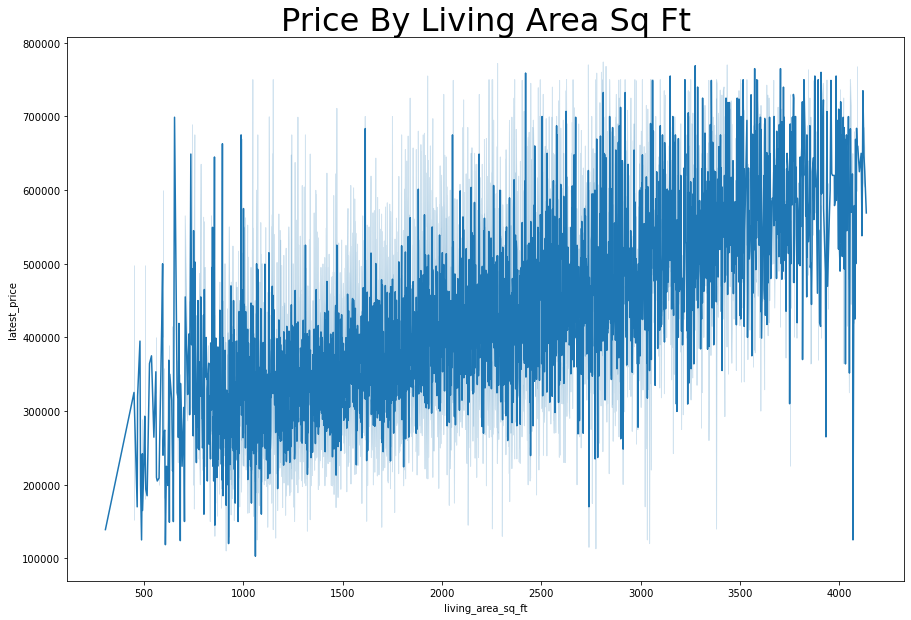

In [63]:
plt.figure(figsize=(15, 10))
plt.title("Price By Living Area Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="living_area_sq_ft", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Distance'}, xlabel='avg_school_distance', ylabel='latest_price'>

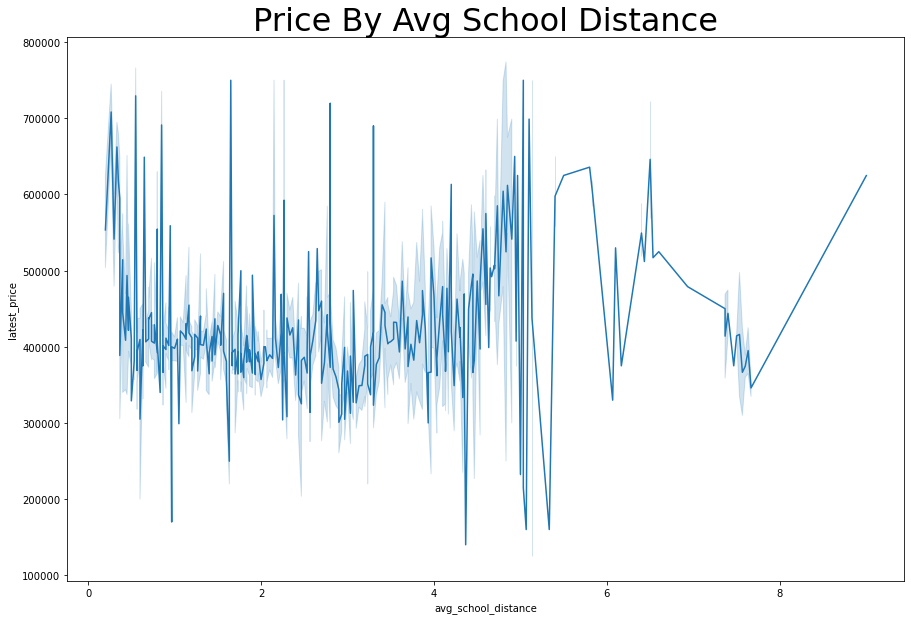

In [64]:
plt.figure(figsize=(15, 10))
plt.title("Price By Avg School Distance", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_distance", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Distance'}, xlabel='avg_school_rating', ylabel='latest_price'>

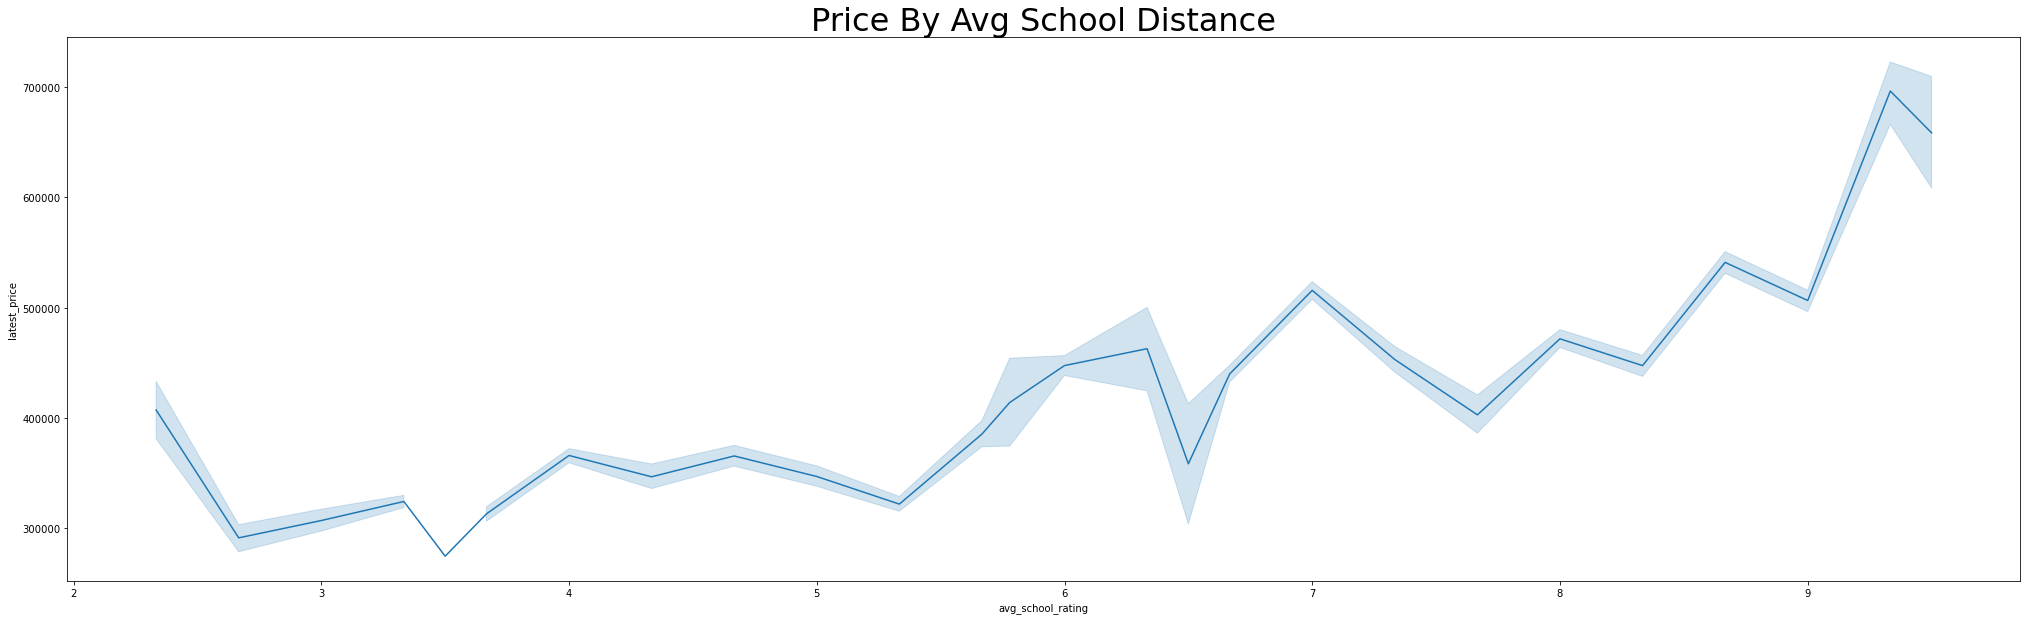

In [65]:
plt.figure(figsize=(35, 10))
plt.title("Price By Avg School Distance", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_rating", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Size'}, xlabel='avg_school_size', ylabel='latest_price'>

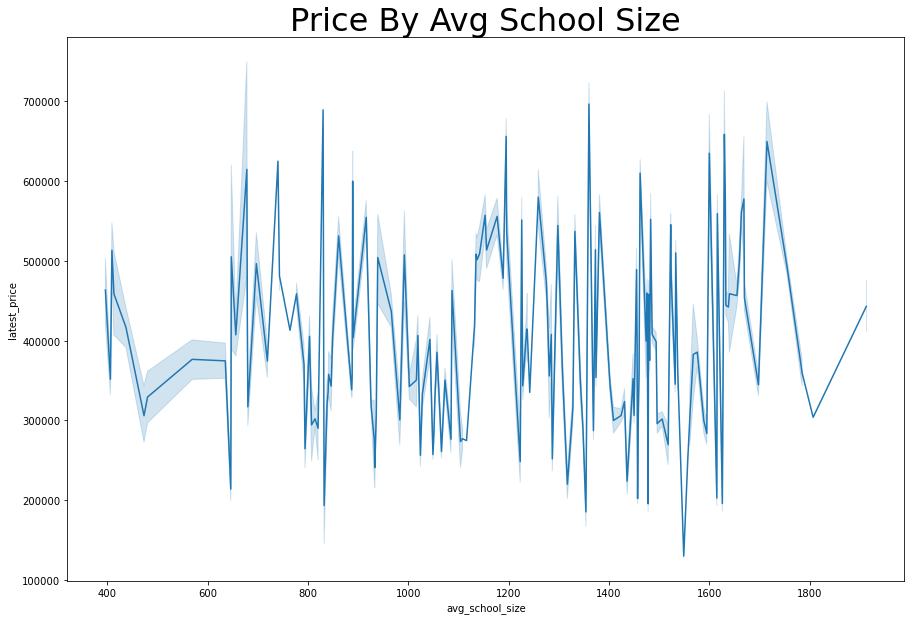

In [69]:
plt.figure(figsize=(15, 10))
plt.title("Price By Avg School Size", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_size", y="latest_price")


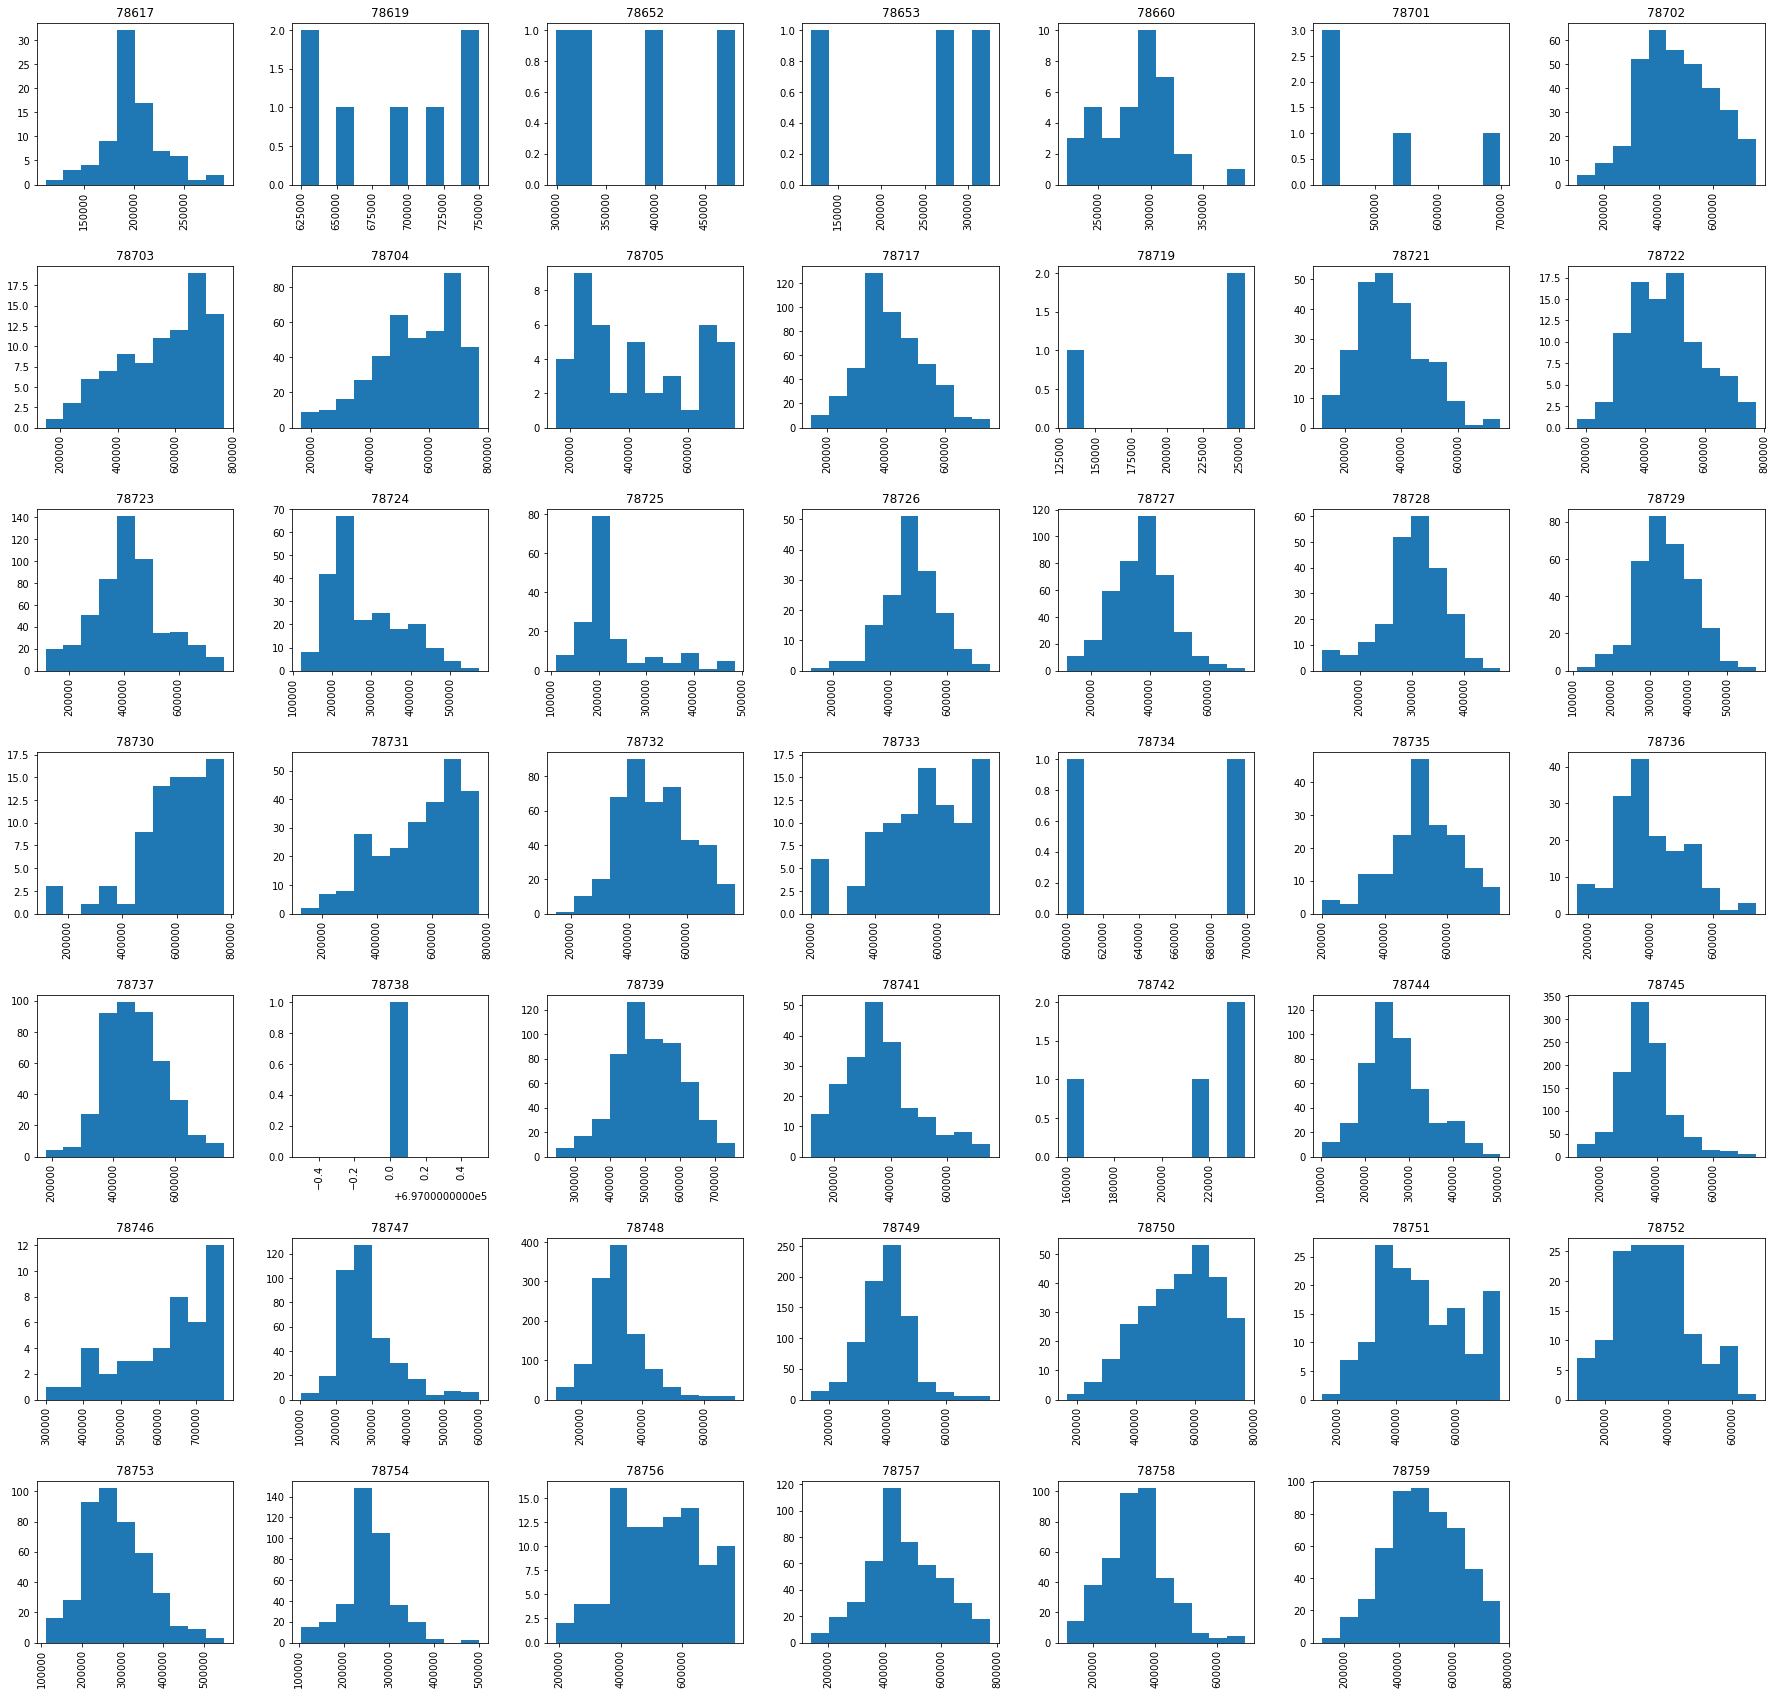

In [70]:
austin_df["latest_price"].hist(by=austin_df["zipcode"], figsize=(30, 30));


In [68]:
# Save preprocessed dataset
austin_df.to_csv("../../data/train.csv", index=False)
